In [2]:
import scipy.io as scio
import numpy as np
import os
from tqdm.auto import tqdm, trange
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import r2_score
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [3]:
os.chdir('/Users/sheeta/Desktop/learn_torch')
lightdata = scio.loadmat('Room_light.mat')
lightdata = torch.Tensor(lightdata['light'])
light = torch.transpose(lightdata,0,1)[0]

In [4]:
#light downsampling
light_down = torch.zeros(1, 389)
for j in range(len(light_down[0])):
    light_down[0][j] = 1/2*(light[2*j]+light[2*j+1])

In [5]:
npcdata = scio.loadmat('NPC_database.mat')
npcdata = torch.Tensor(npcdata['NPC_spec'])
npc = torch.transpose(npcdata,0,1)

In [6]:
#npc downsampling
npc_down = torch.zeros(4147, 389)
for i in range(len(npc_down)):
    for j in range(len(npc_down[0])):
        npc_down[i,j] = 1/2*(npc[i,2*j]+npc[i,2*j+1])

In [7]:
noise_standard = 0.13
ao = light_down[0] <= noise_standard
bo = light_down[0] >= noise_standard
indices1 = ao.nonzero()
indices1 = torch.flatten(indices1)
indices2 = bo.nonzero()
indices2 = torch.flatten(indices2)



In [8]:
len(indices2)

49

In [9]:
orig_npc = torch.index_select(npc_down, 1, indices1)
miss_npc = torch.index_select(npc_down, 1, indices2)

class Dataset(object):
    def __init__(self, orig_npc, miss_npc):

        self.ori_npc = orig_npc
        self.miss_npc = miss_npc
        self.training_data = []

    def __len__(self):
        return len(self.orig_npc)

    def get_traindata(self):
        for i in range(len(self.miss_npc)):
            self.training_data.append([np.array(self.ori_npc[i]),np.array(self.miss_npc[i])])              
        np.save("training_data.npy", self.training_data)                  

Dataset = Dataset(orig_npc, miss_npc)
Dataset.get_traindata()
training_data = np.load("training_data.npy", allow_pickle=True)


X = torch.Tensor([i[0] for i in training_data]).view(-1,1,len(orig_npc[0]))
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.9 
train_size = int(len(X)*VAL_PCT)
test_size = len(X) - train_size

train_X, test_X = torch.utils.data.random_split(X, [train_size, test_size])
train_y, test_y = torch.utils.data.random_split(y, [train_size, test_size])


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


In [28]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        torch.manual_seed(20010315)
        super(LSTM, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # LSTM layers
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Initializing cell state for first input with zeros
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # Forward propagation by passing in the input, hidden state, and cell state into the model
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

In [48]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__() 
        torch.manual_seed(20010315)
        self.conv1 = nn.Conv1d(1, 32,5 ,padding = 2)
        self.conv2 = nn.Conv1d(32, 64, 5,padding = 2) 
        self.conv3 = nn.Conv1d(64, 128, 5,padding = 2)
        self.D = nn.Dropout(0.2)
      #  self.lstm = nn.LSTM(input_size=len(orig_npc[0]), hidden_size=256, num_layers=3)
        x = torch.randn(len(orig_npc[0])).view(-1,1,len(orig_npc[0]))
        self._to_linear = None
        self.convs(x)
        self.fc1 = nn.Linear(self._to_linear, len(miss_npc[0])) #flattening.
    
    def convs(self, x):
        x = F.max_pool1d(F.relu(self.conv1(x)), (2))
        x = F.max_pool1d(F.relu(self.conv2(x)), (2))
        x = F.max_pool1d(F.relu(self.conv3(x)), (2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]
        return x
    

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)  # .view is reshape ... this flattens X before 
        x = self.D(x)
#         x = F.relu(self.fc1(x))
        x = self.fc1(x) # bc this is our output layer. No activation here.
        return x
net = CNN()

In [11]:
def fwd_pass(X,y,train = False):
    if train:
        net.zero_grad()
    
    output = net(X)
    loss = loss_function(output,y)
    
    output = output.detach().numpy()
    score  = [r2_score(i,j) for i, j in zip(output, y)]
    score = np.mean(score)
    if train:
        loss.backward()
        optimizer.step()
    return loss, score
    

In [53]:
def get_model(model, model_params):
    models = {
       # "cnn": CNN,
        "lstm": LSTM,
      #  "gru": GRU,
    }
    return models.get(model.lower())(**model_params)

In [57]:
def test(size=32):
    with torch.no_grad():
        randome_start = np.random.randint(len(test_X)-size)
        X, y = test_X[randome_start:randome_start+size], test_y[randome_start:randome_start+size]
        loss,r2score = fwd_pass(X.view(-1, 1, 340),y)
    return loss,r2score

loss, r2score = test(size = 414)
print(loss,r2score)

tensor(0.0810) 0.8769495377628947


In [54]:
input_dim = len(orig_npc[0])
output_dim = len(miss_npc[0])
hidden_dim = 64
layer_dim = 2
dropout = 0.2
learning_rate = 1e-3
weight_decay = 1e-6

model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}
net = get_model('lstm', model_params)


In [56]:
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
loss_function = nn.MSELoss()
def train(net = net,
          epochs=3,
          BATCH_SIZE = 20):


    for e in trange(epochs):
        for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
            batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,len(orig_npc[0]))
            batch_y = train_y[i:i+BATCH_SIZE].view(-1,1,len(miss_npc[0])).squeeze(1)
            loss,score = fwd_pass(batch_X, batch_y, train=True)
        print('Train','loss:', loss, 'score:' ,score )
        loss_test, r2score_test = test(size = 40)
        print('Test','loss:', loss_test, 'score:' ,r2score_test )
        
train()

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/187 [00:00<?, ?it/s]

Train loss: tensor(0.0989, grad_fn=<MseLossBackward>) score: 0.8537793306559323
Test loss: tensor(0.0809) score: 0.8765557085479451


  0%|          | 0/187 [00:00<?, ?it/s]

Train loss: tensor(0.1064, grad_fn=<MseLossBackward>) score: 0.8387448312406907
Test loss: tensor(0.0663) score: 0.9005199291357091


  0%|          | 0/187 [00:00<?, ?it/s]

Train loss: tensor(0.1004, grad_fn=<MseLossBackward>) score: 0.8477803575027737
Test loss: tensor(0.0749) score: 0.8857976671663295


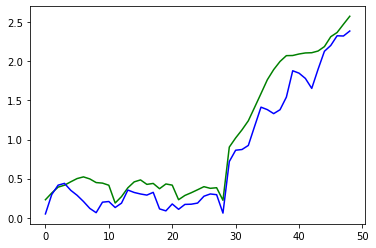

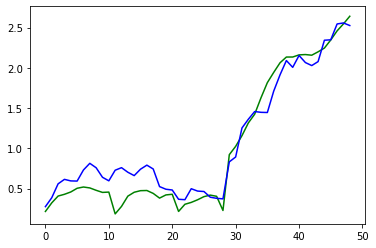

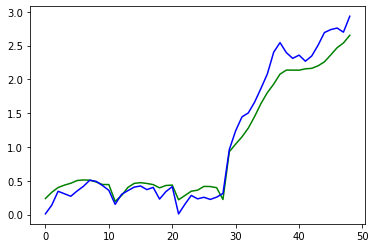

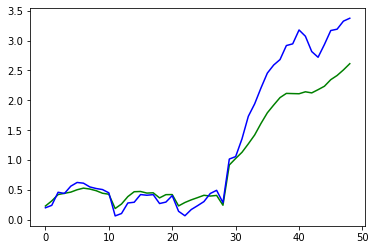

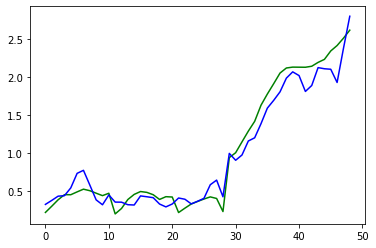

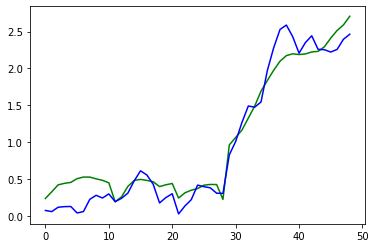

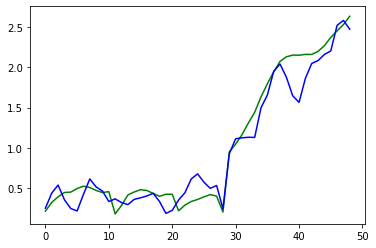

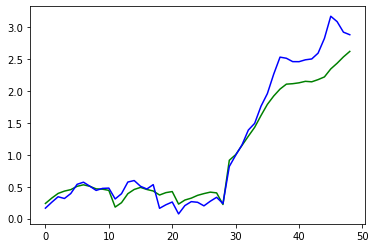

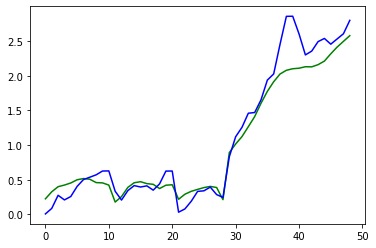

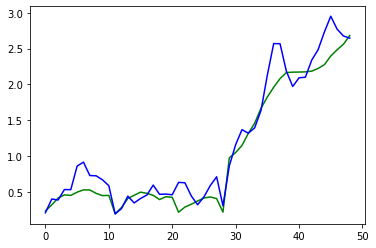

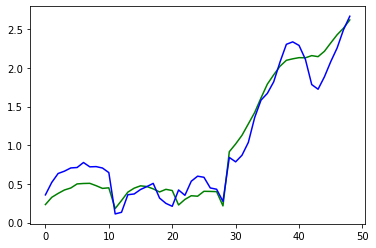

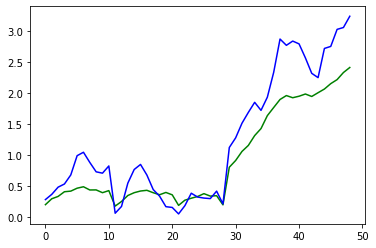

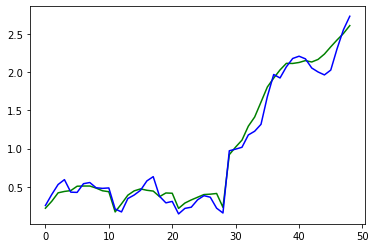

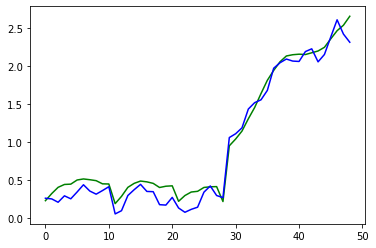

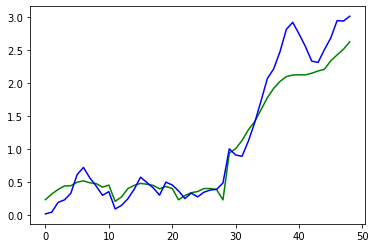

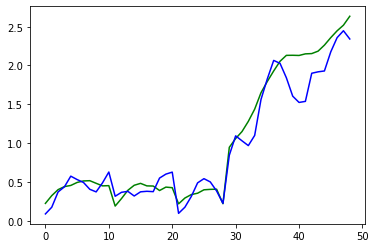

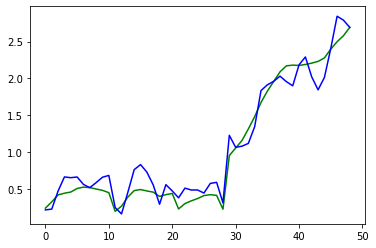

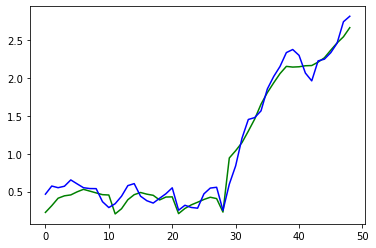

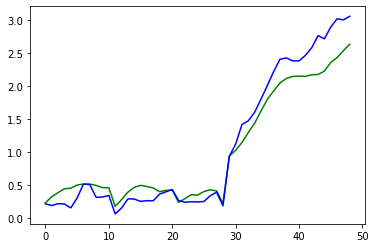

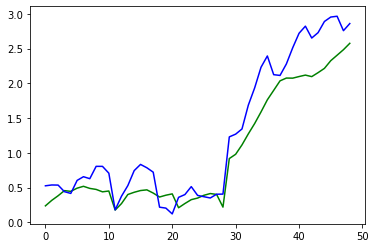

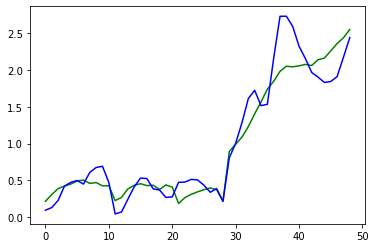

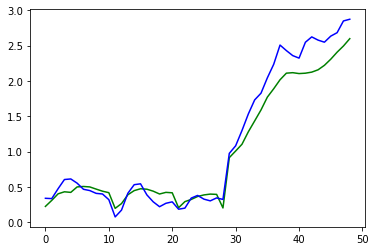

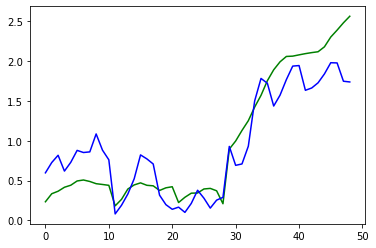

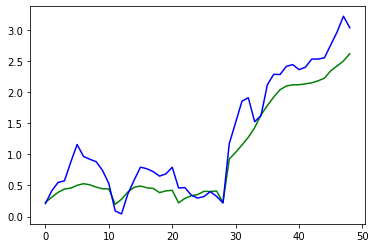

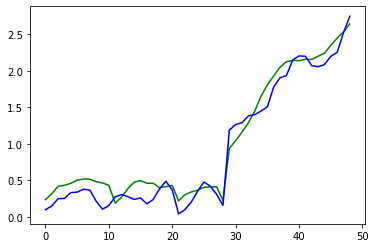

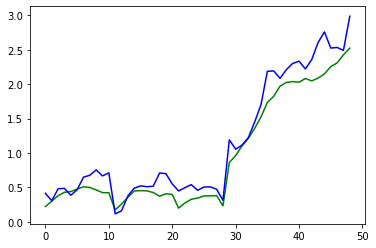

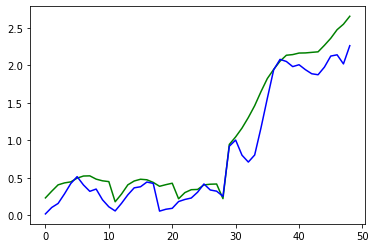

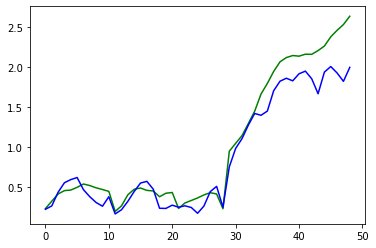

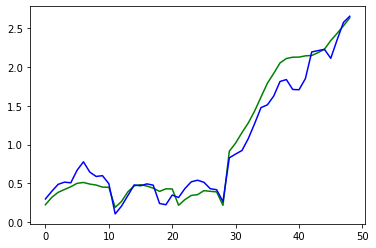

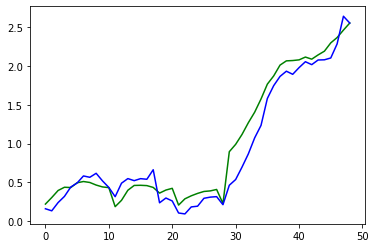

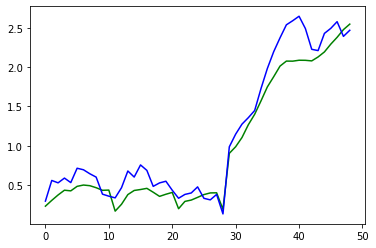

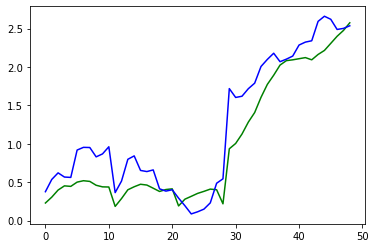

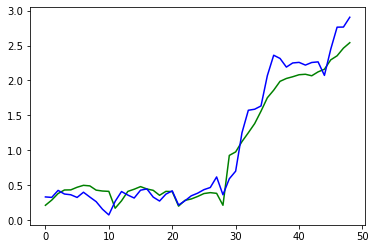

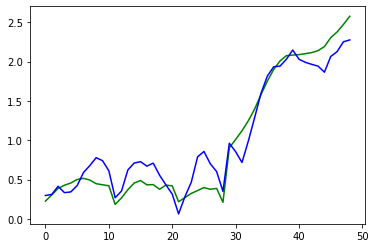

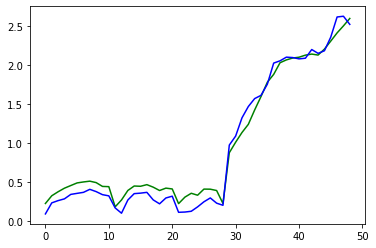

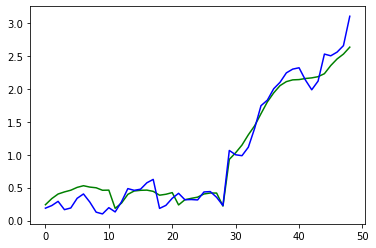

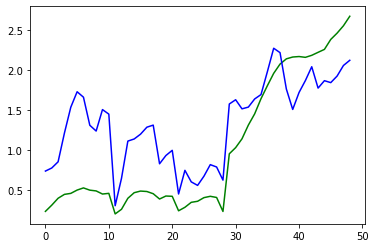

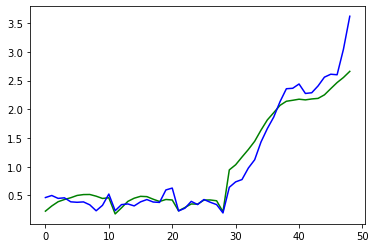

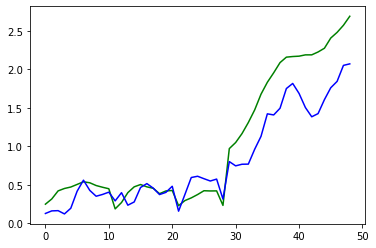

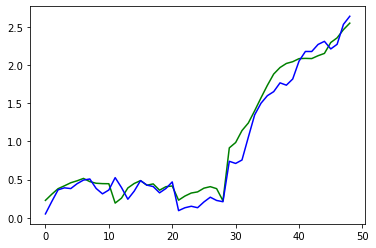

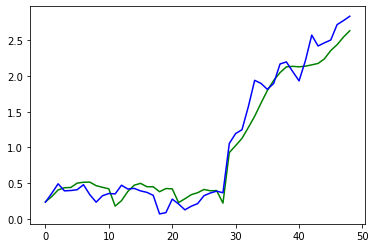

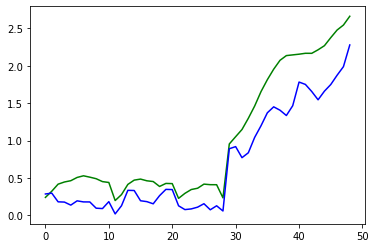

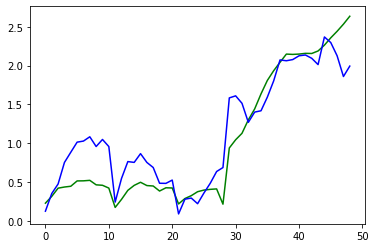

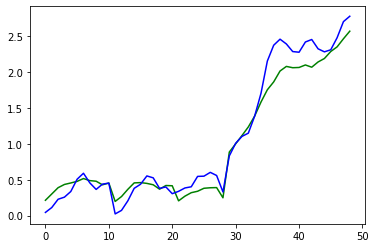

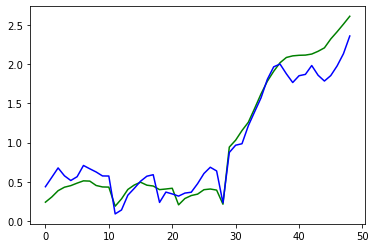

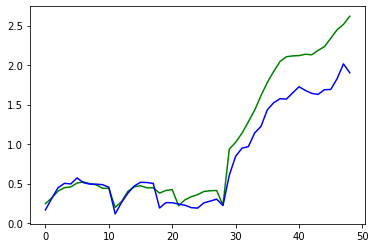

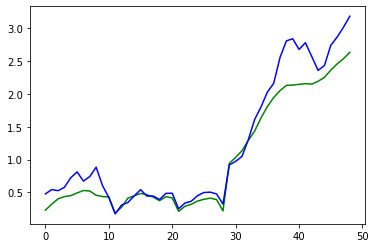

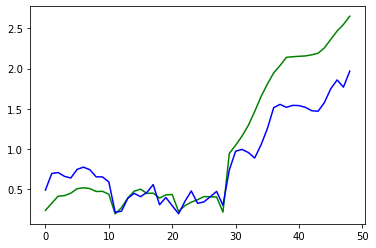

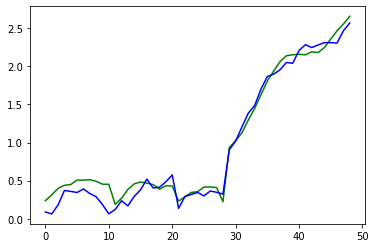

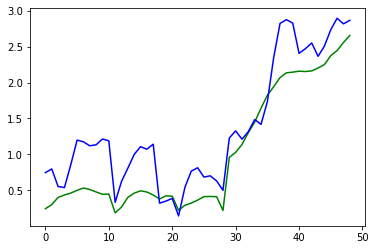

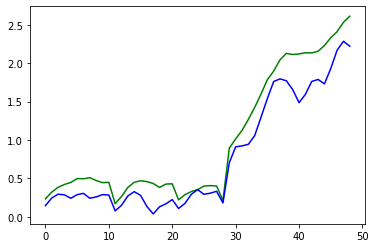

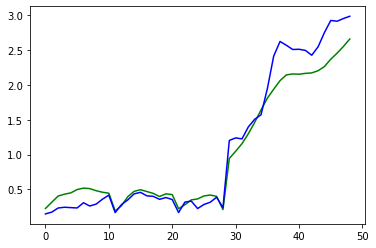

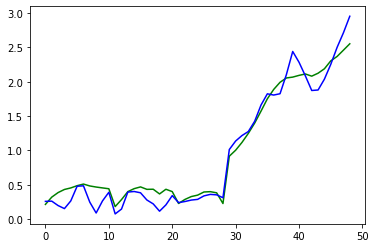

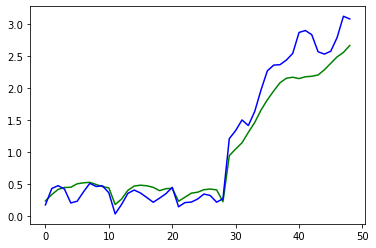

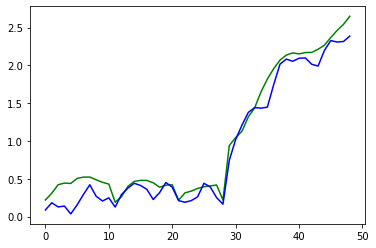

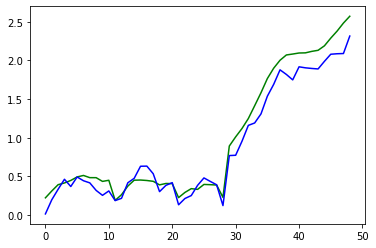

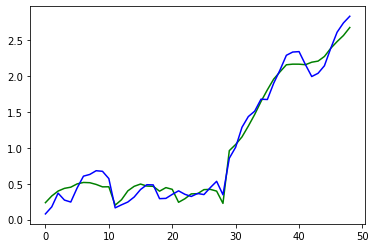

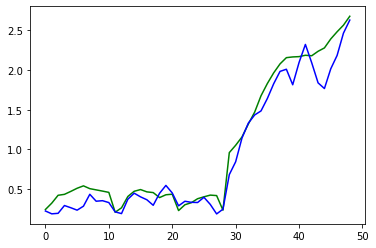

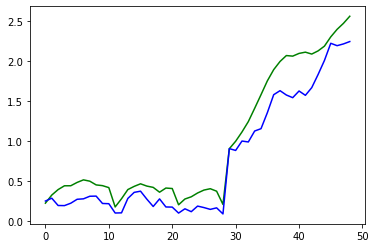

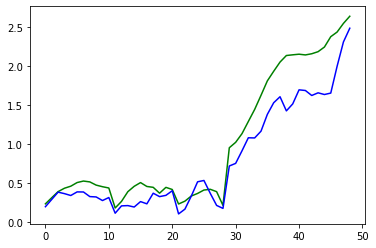

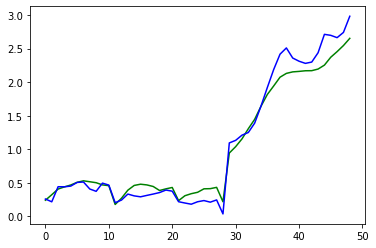

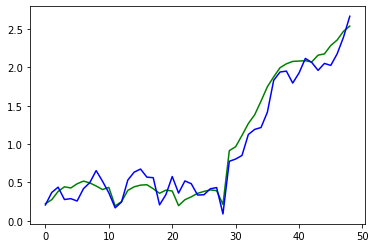

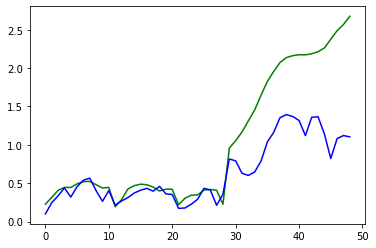

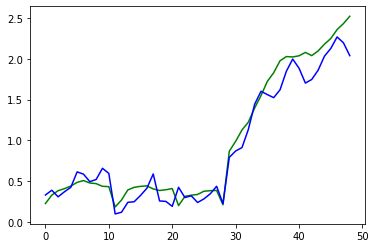

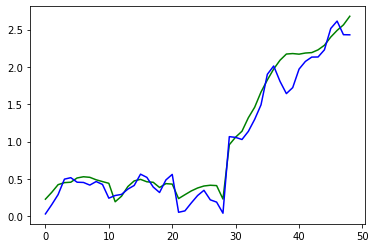

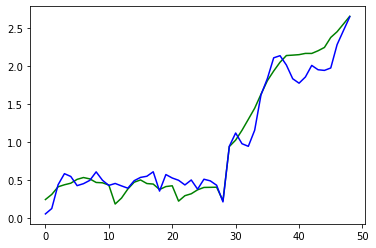

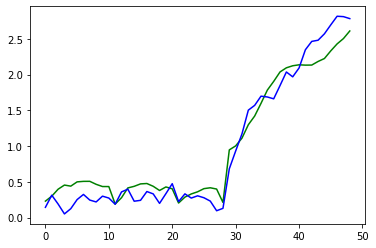

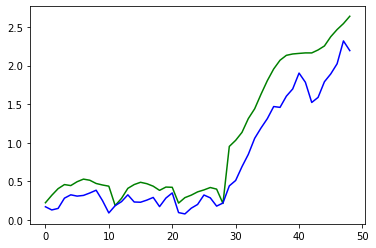

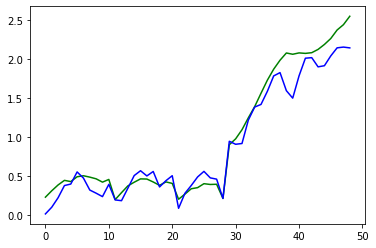

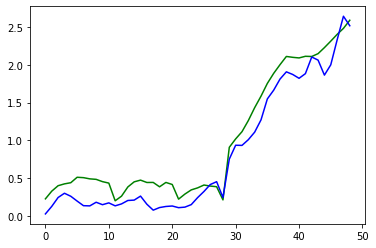

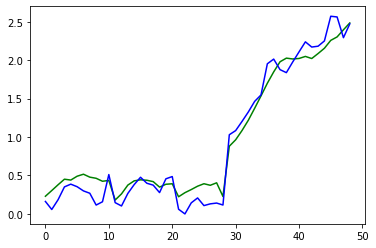

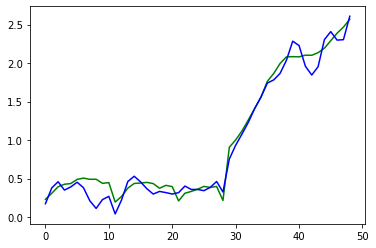

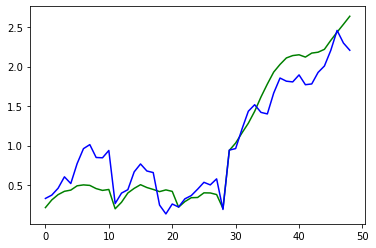

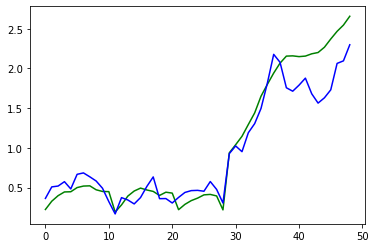

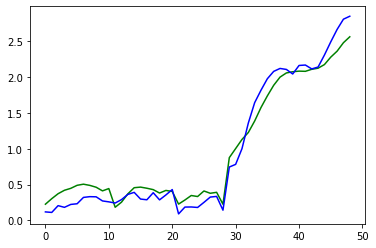

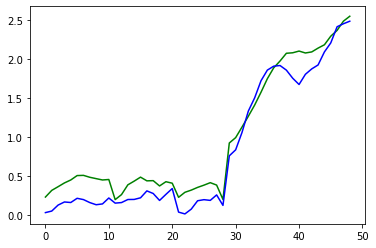

Exception ignored in: <function TransformNode.set_children.<locals>.<lambda> at 0x7fb4ad1590d0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/matplotlib/transforms.py", line 200, in <lambda>
    self, lambda _, pop=child._parents.pop, k=id(self): pop(k))
KeyboardInterrupt: 


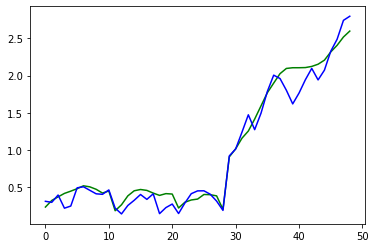

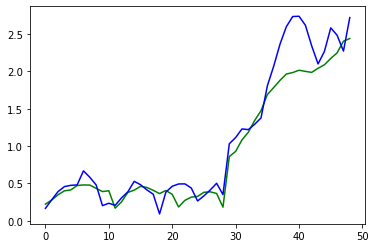

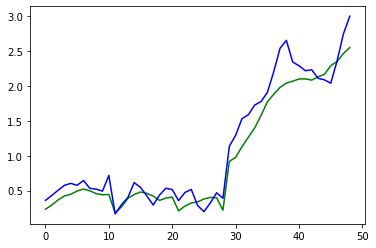

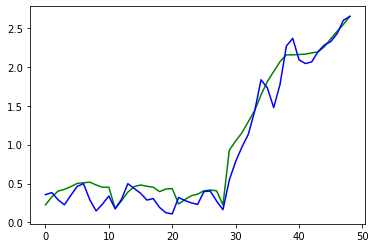

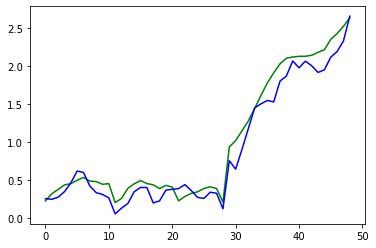

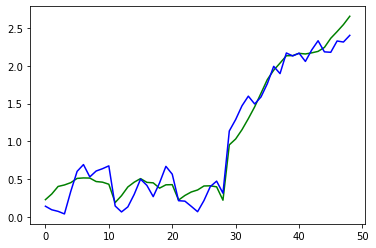

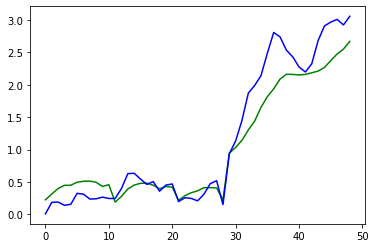

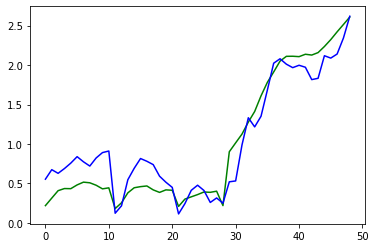

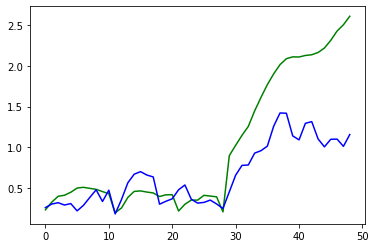

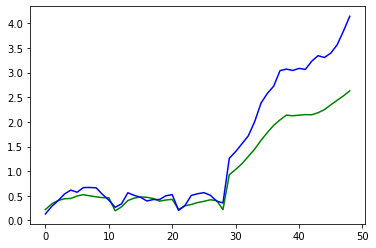

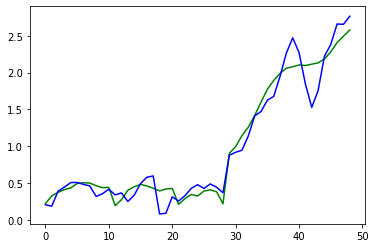

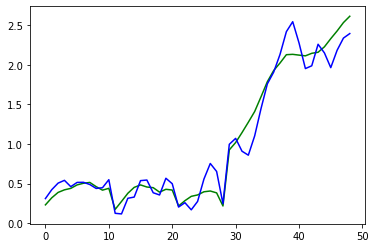

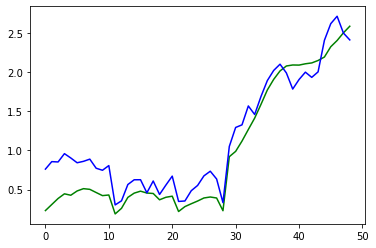

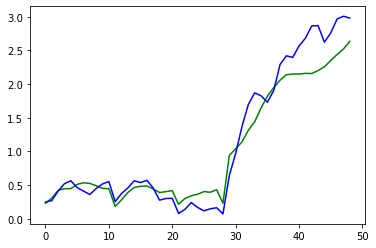

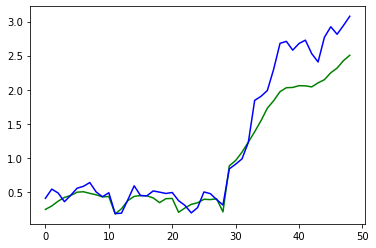

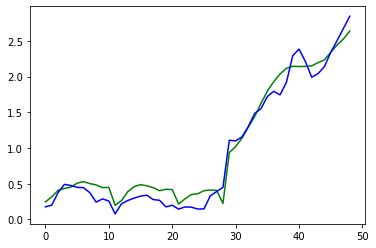

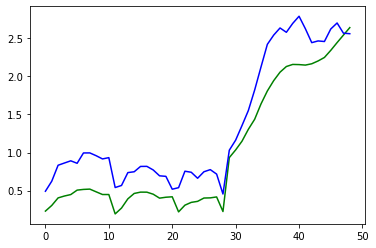

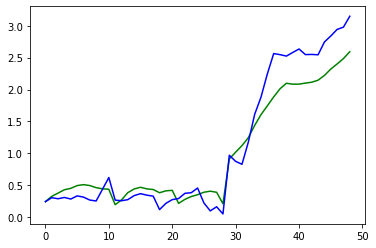

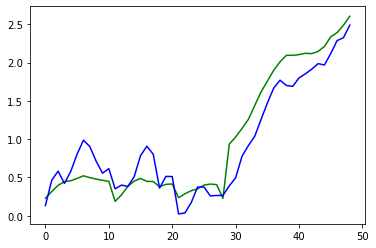

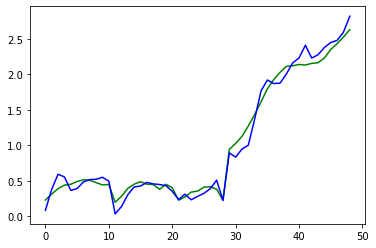

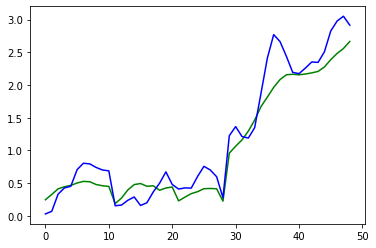

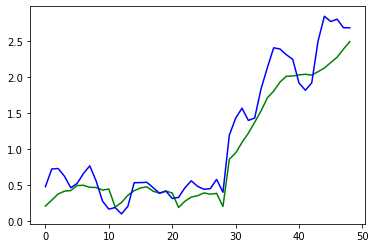

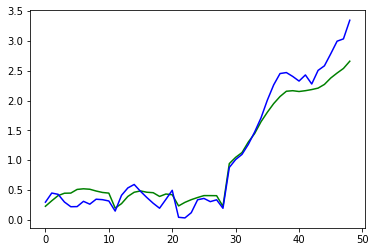

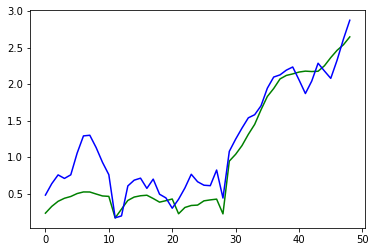

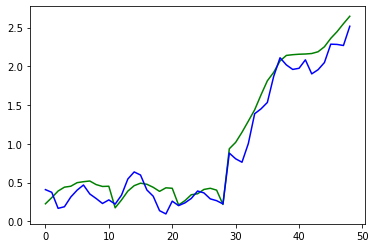

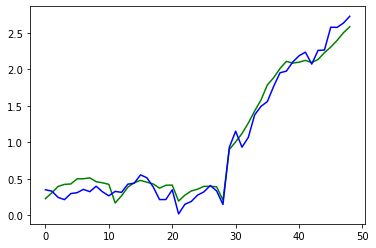

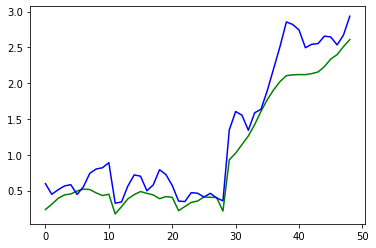

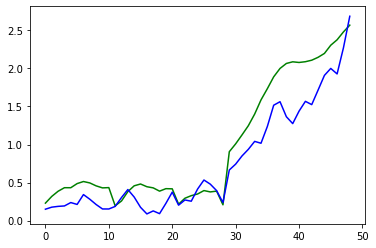

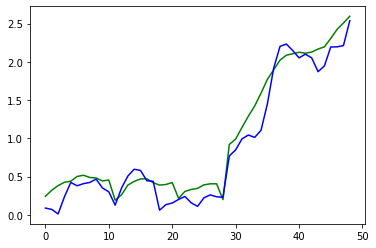

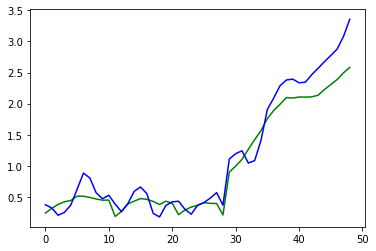

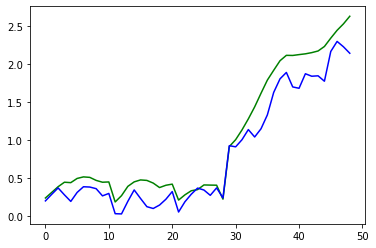

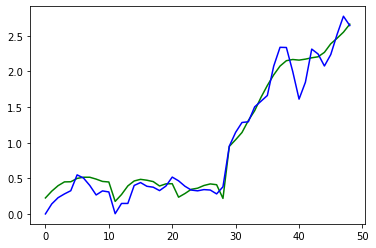

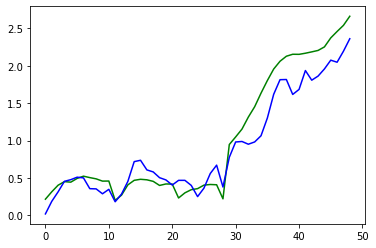

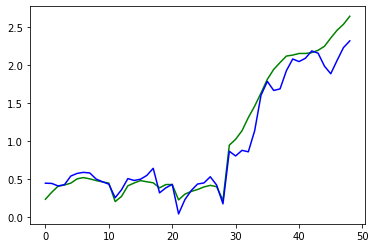

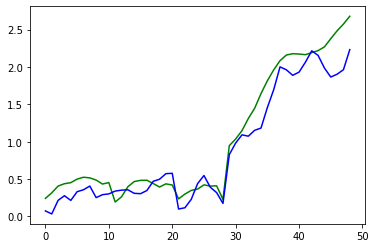

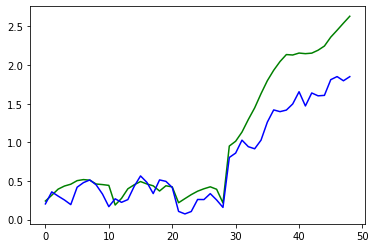

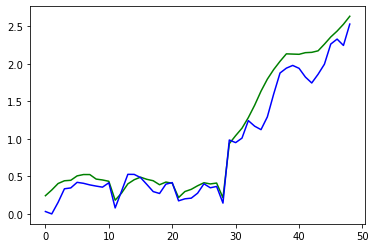

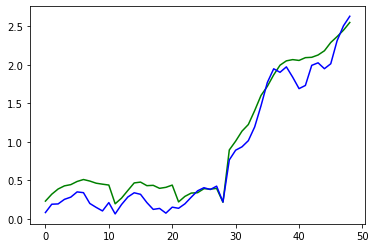

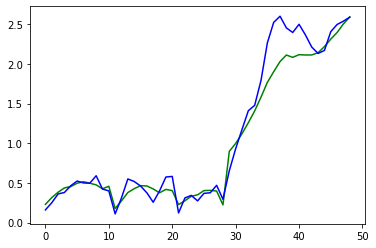

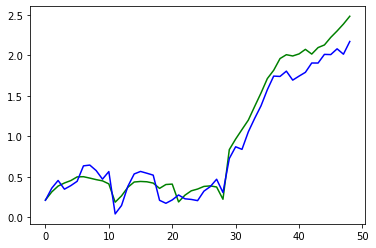

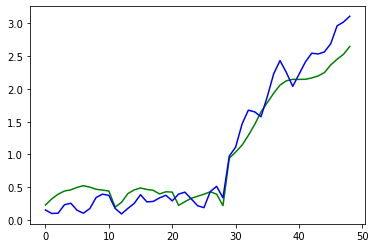

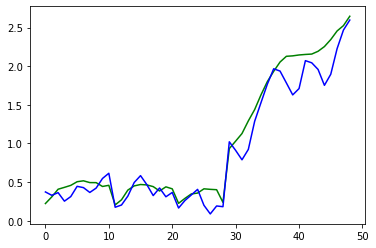

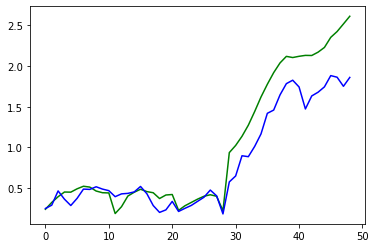

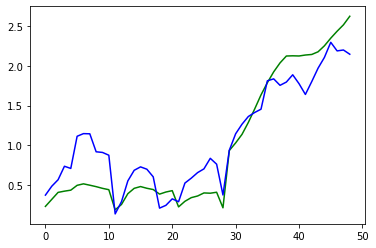

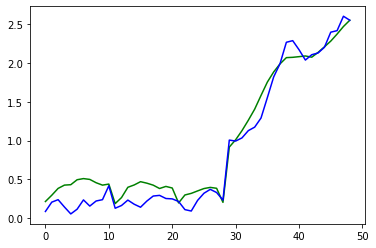

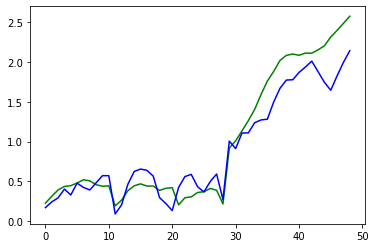

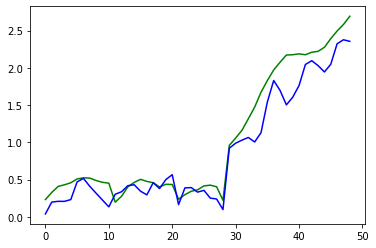

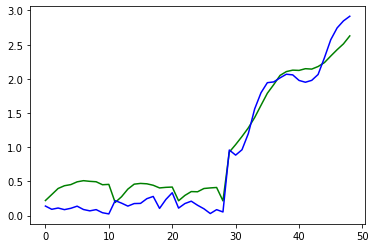

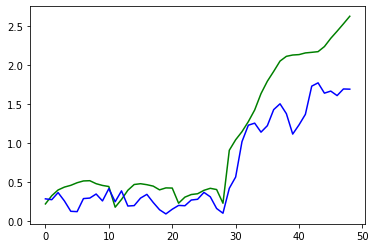

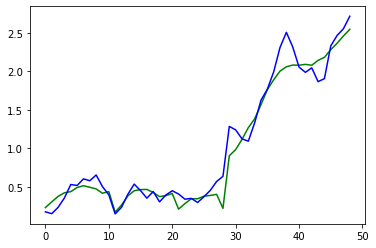

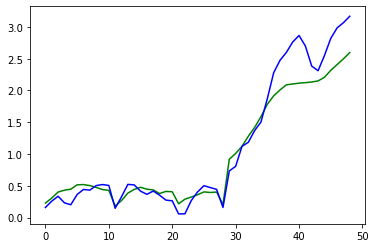

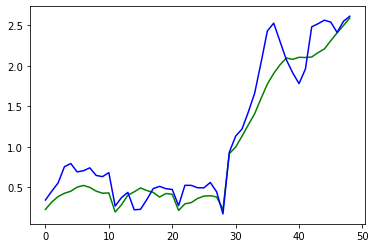

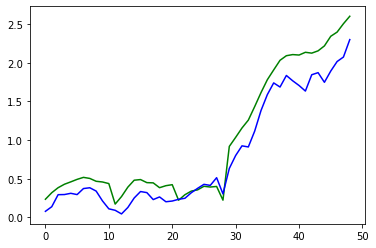

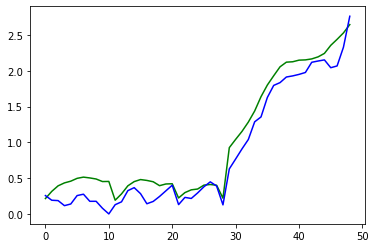

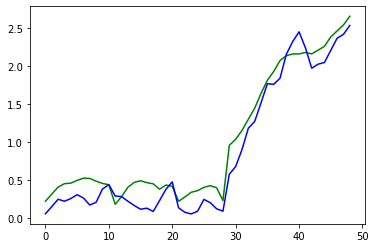

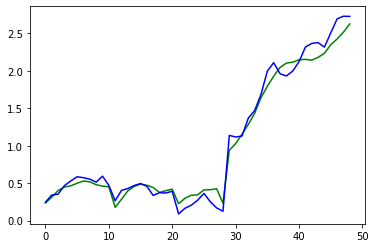

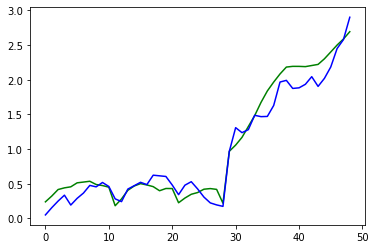

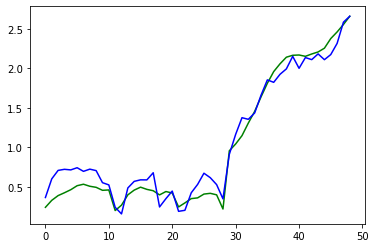

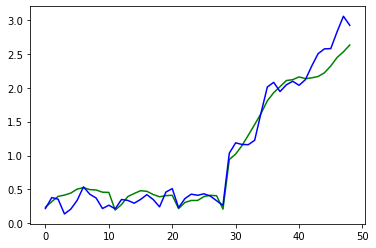

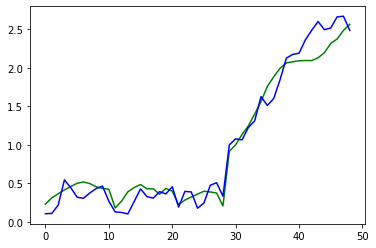

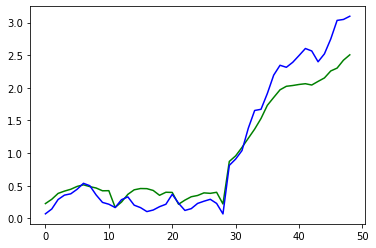

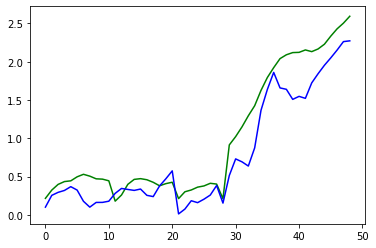

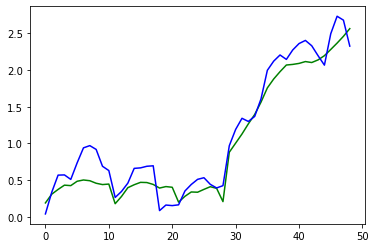

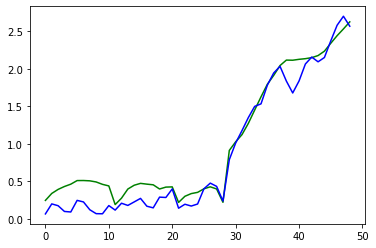

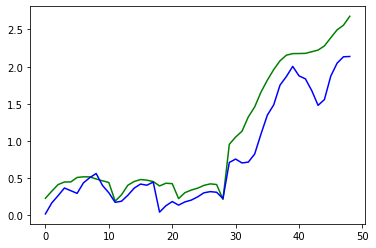

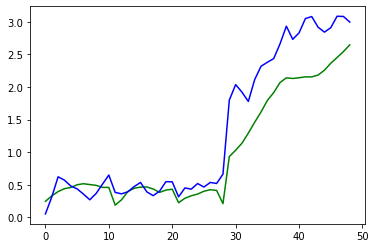

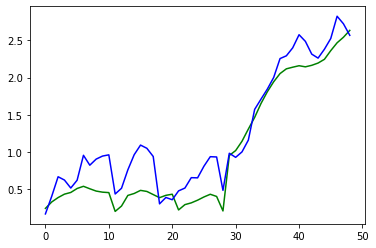

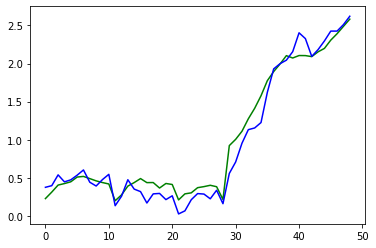

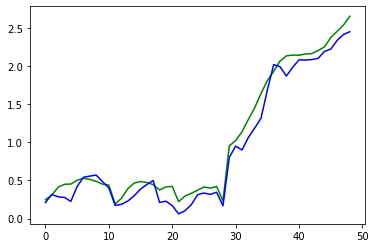

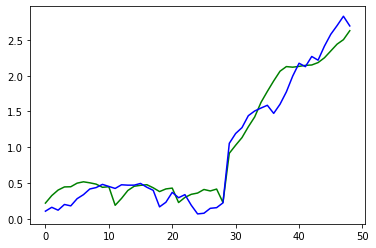

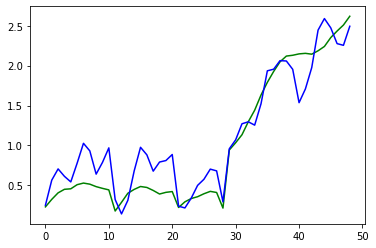

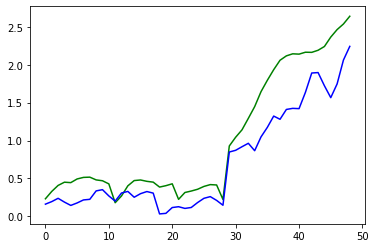

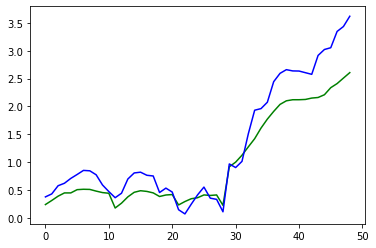

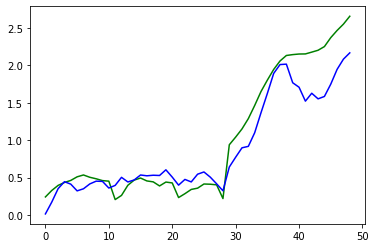

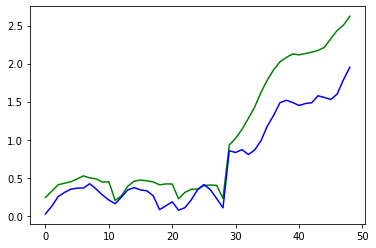

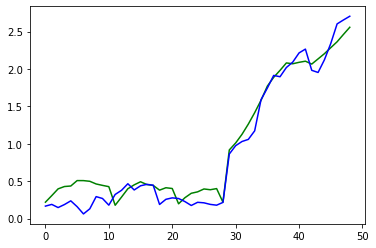

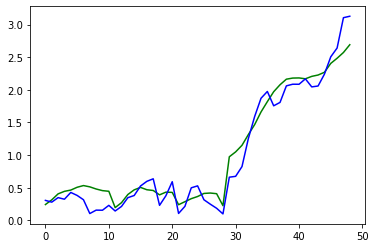

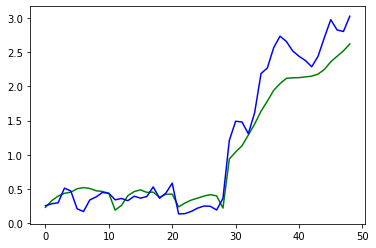

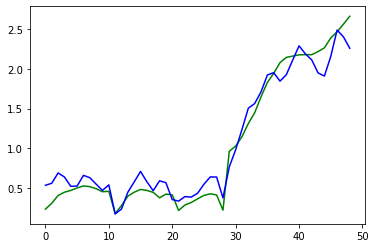

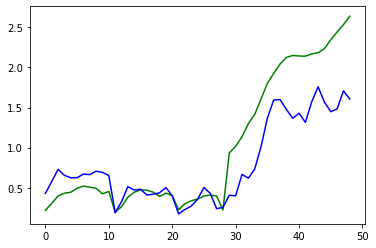

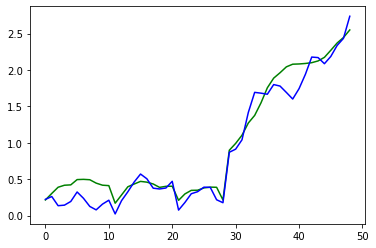

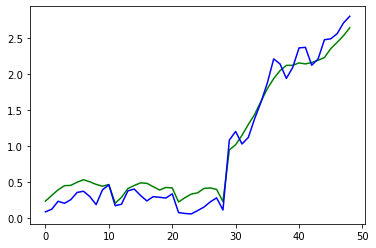

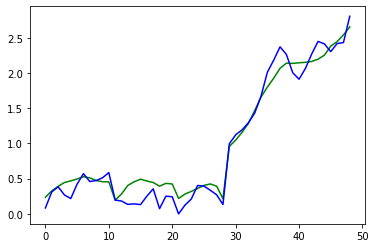

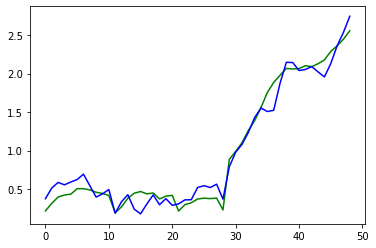

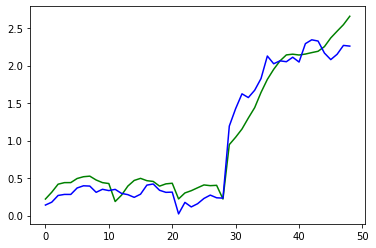

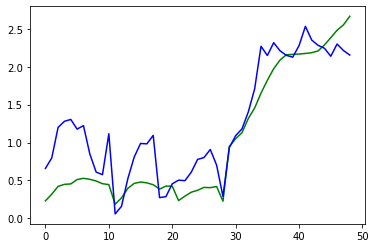

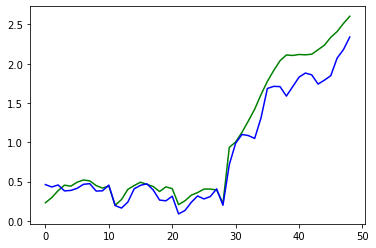

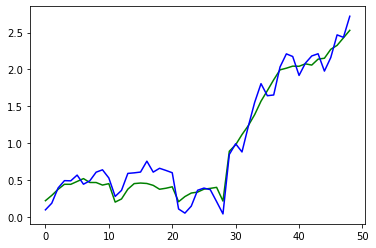

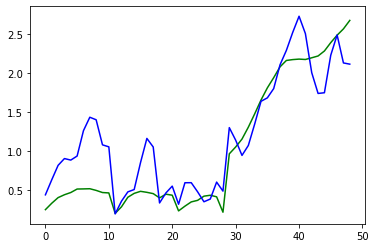

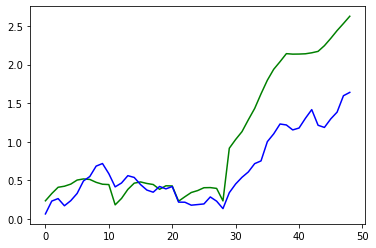

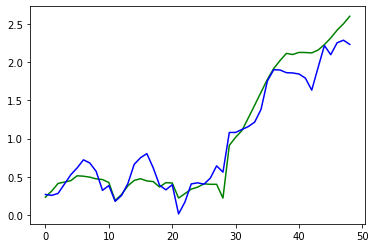

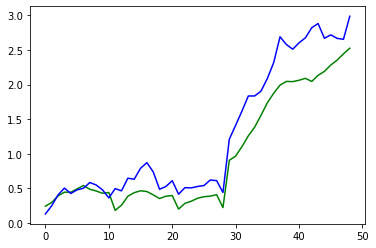

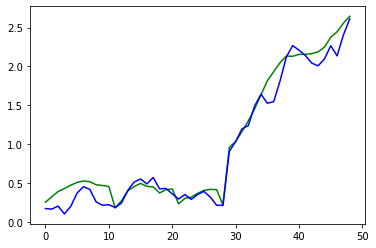

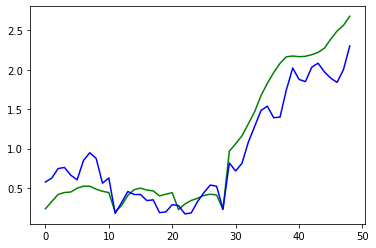

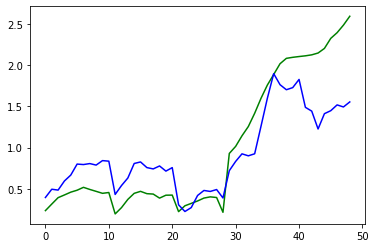

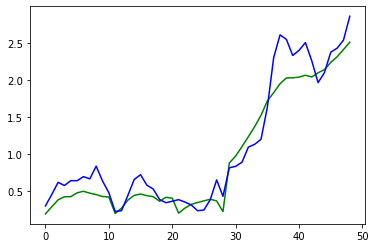

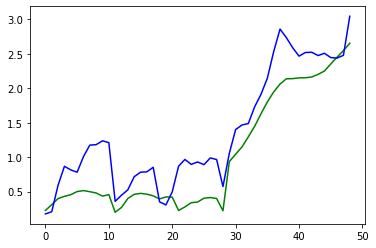

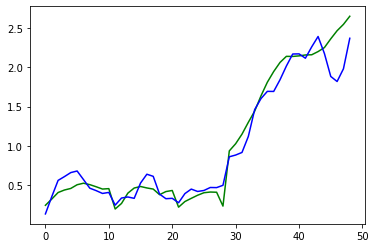

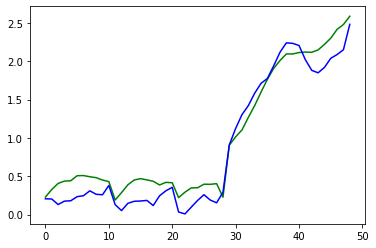

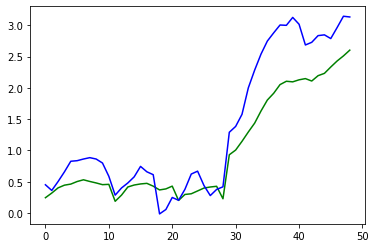

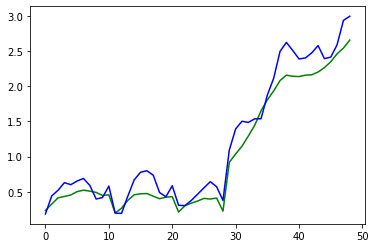

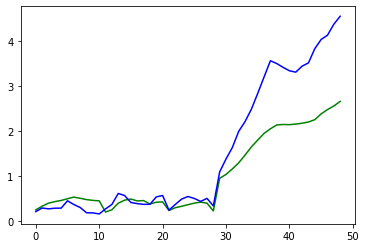

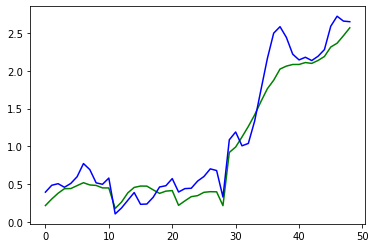

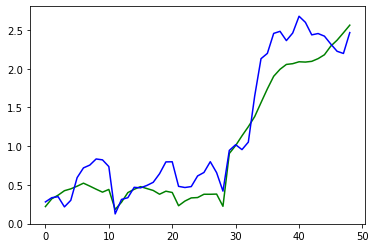

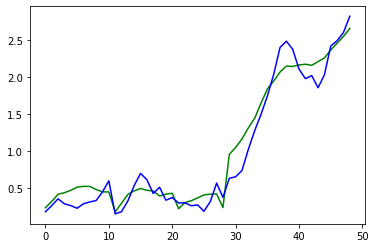

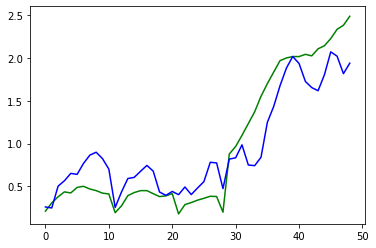

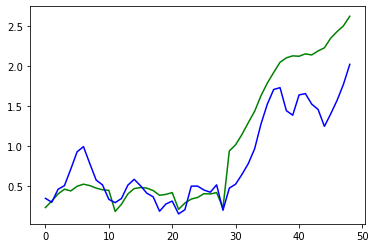

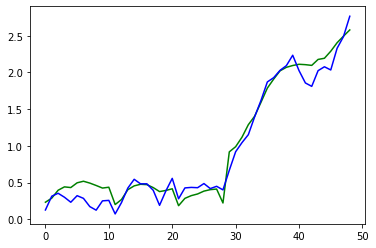

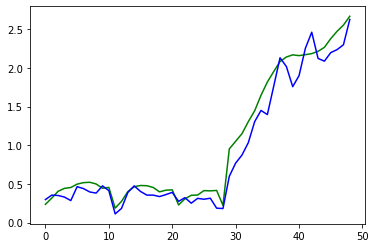

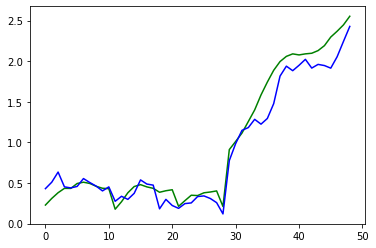

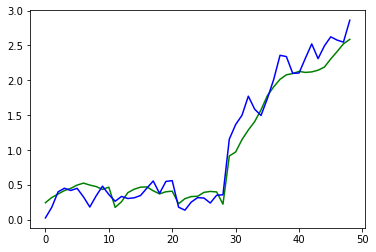

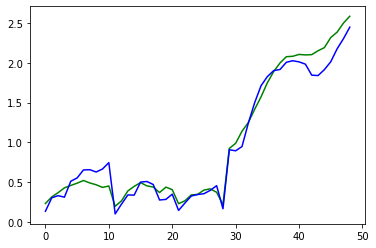

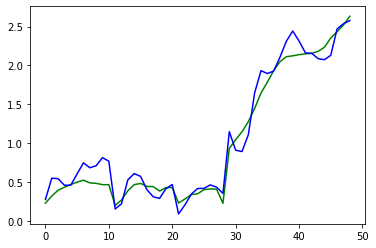

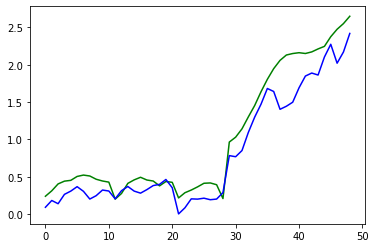

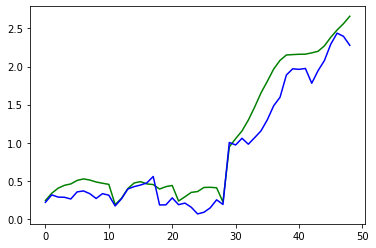

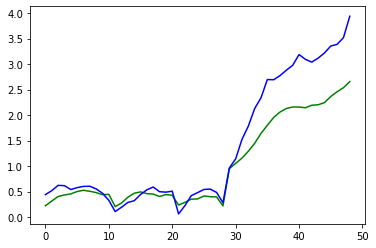

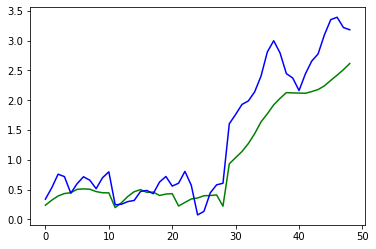

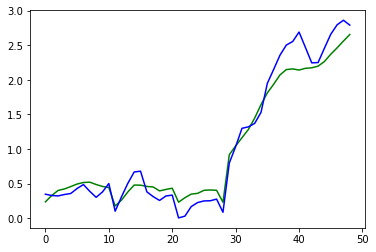

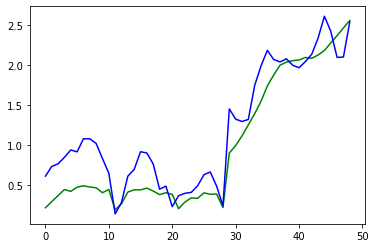

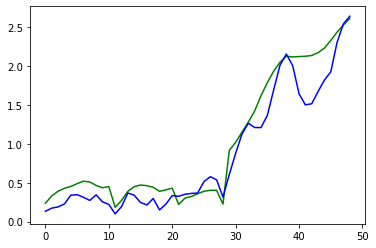

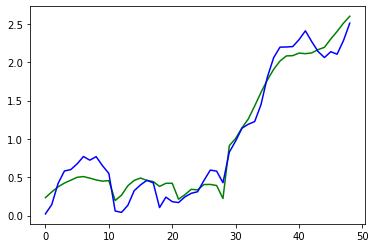

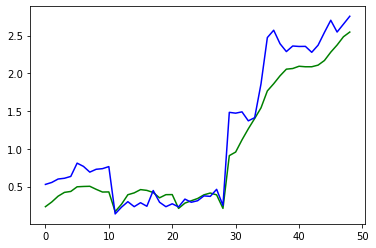

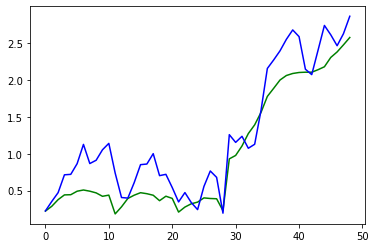

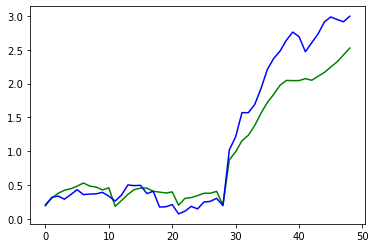

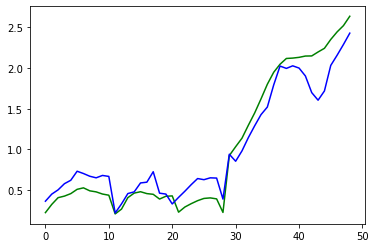

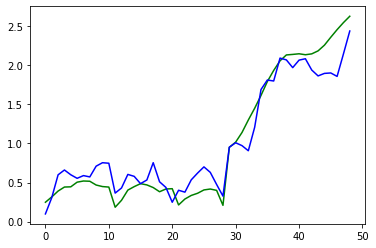

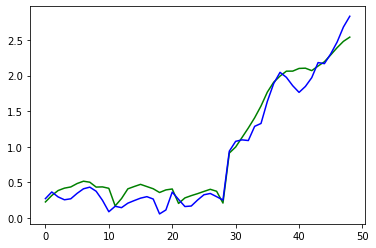

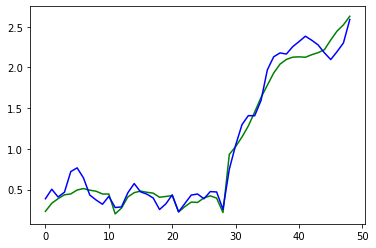

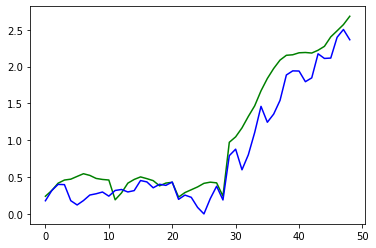

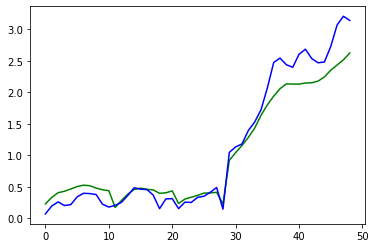

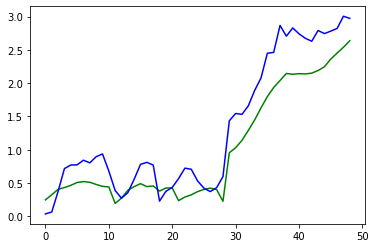

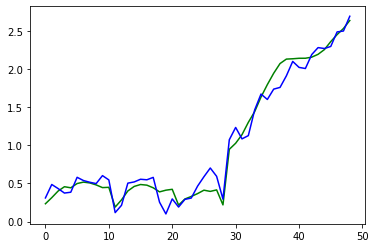

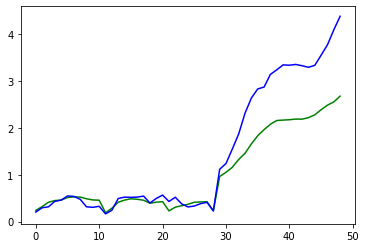

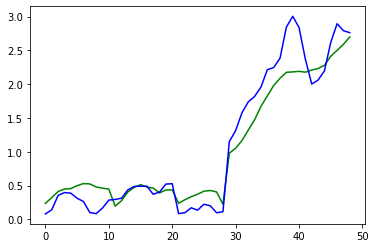

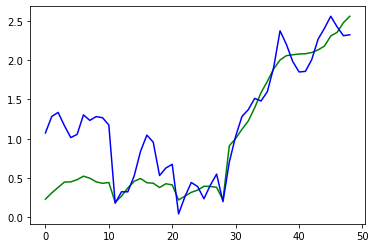

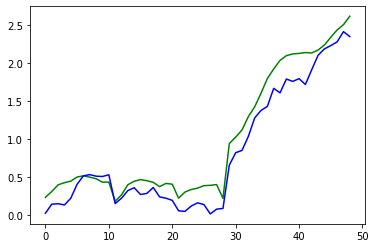

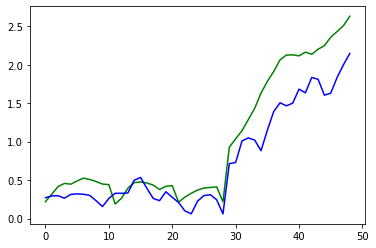

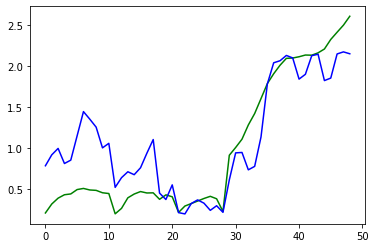

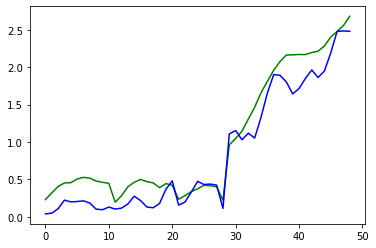

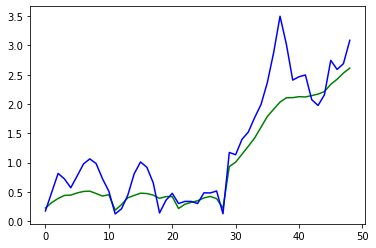

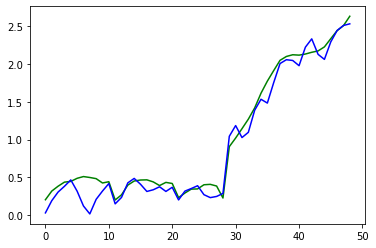

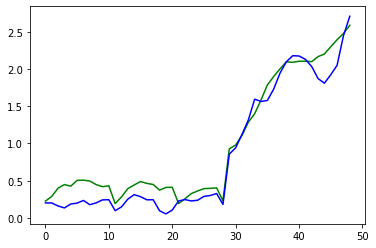

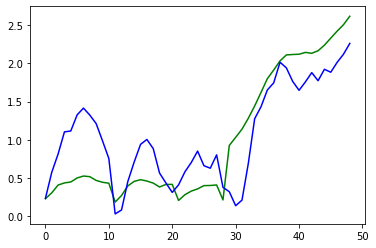

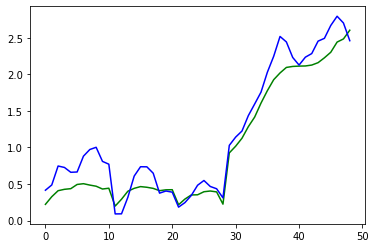

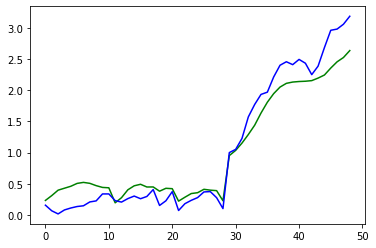

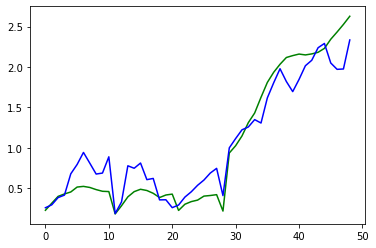

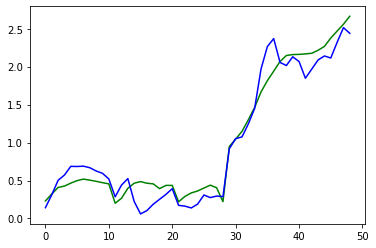

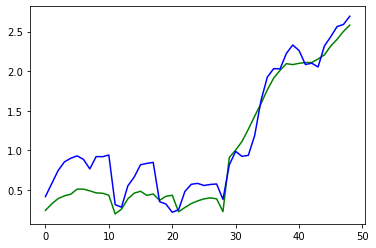

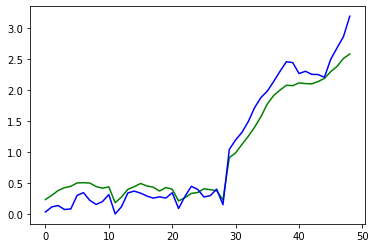

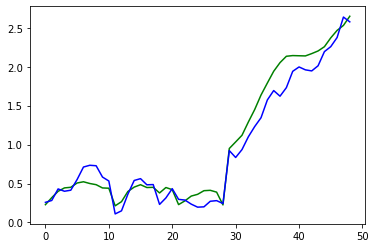

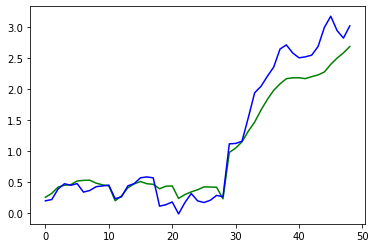

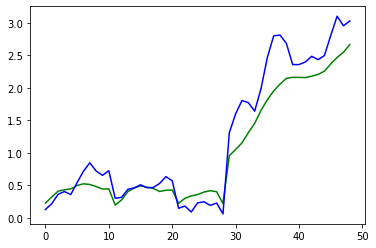

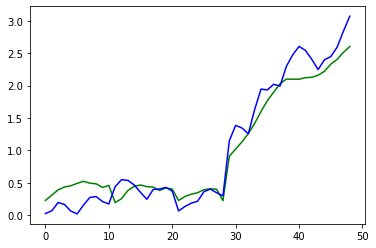

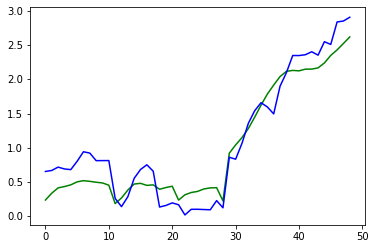

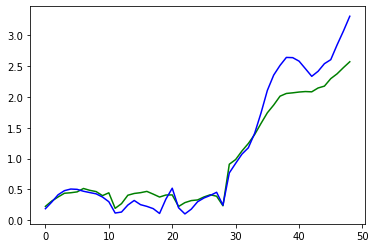

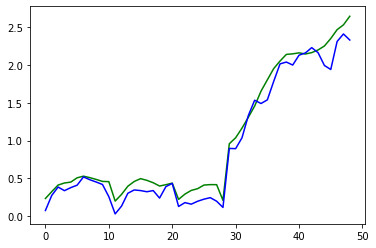

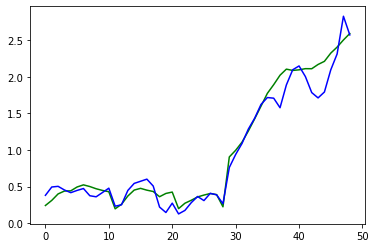

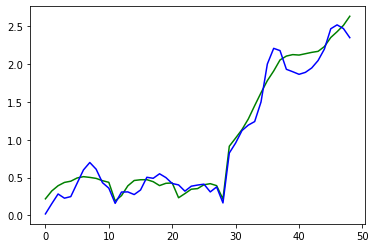

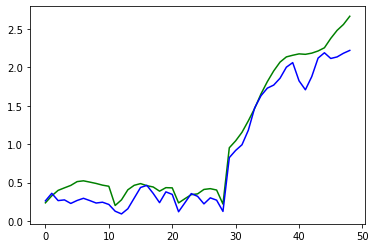

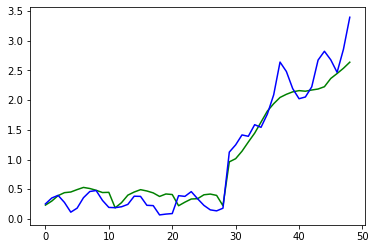

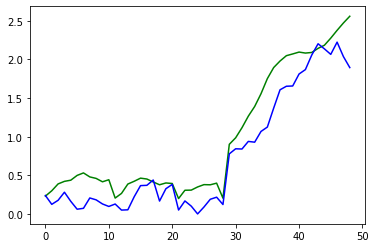

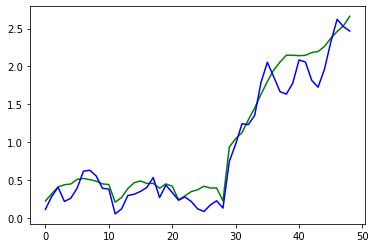

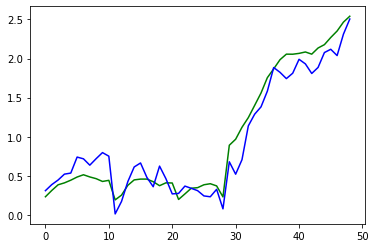

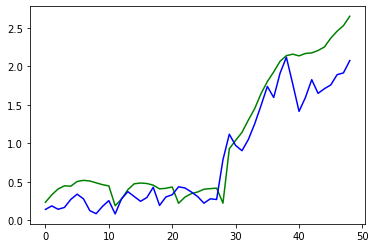

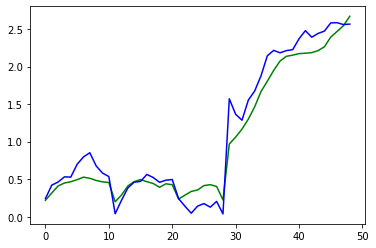

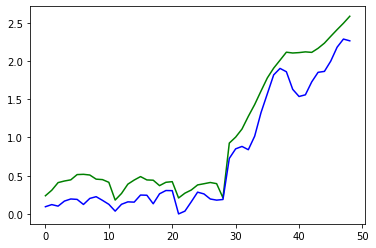

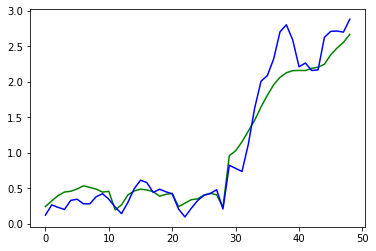

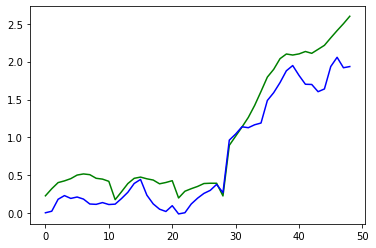

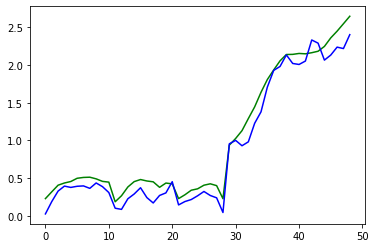

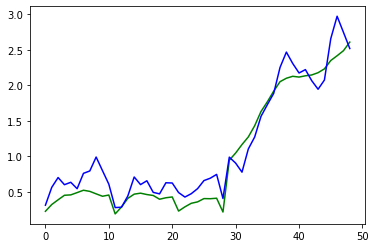

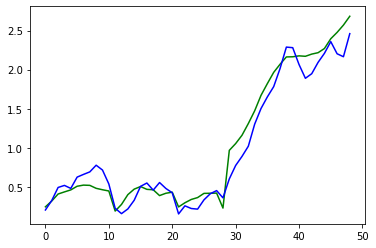

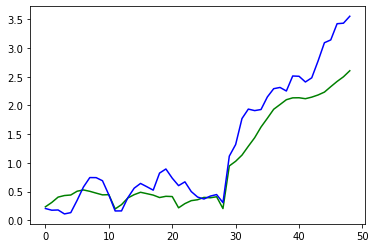

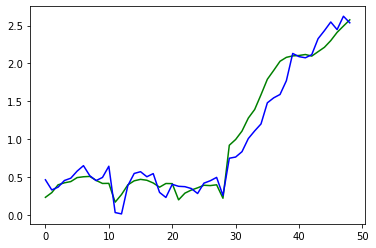

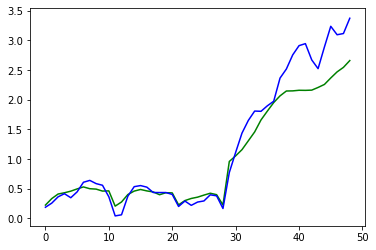

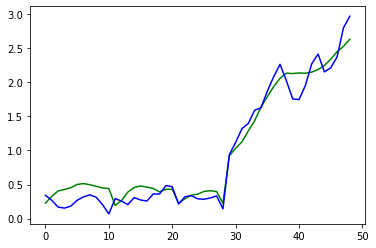

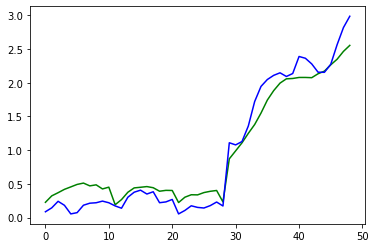

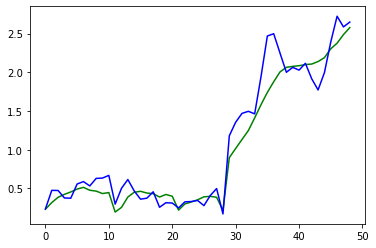

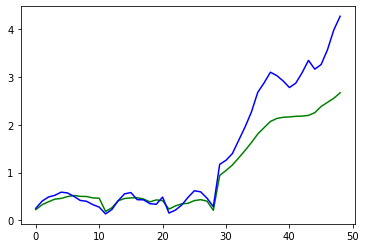

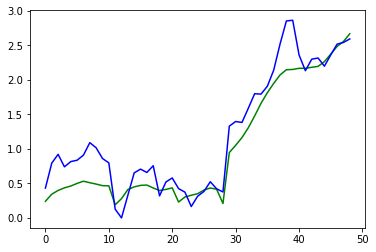

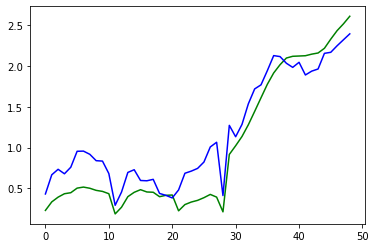

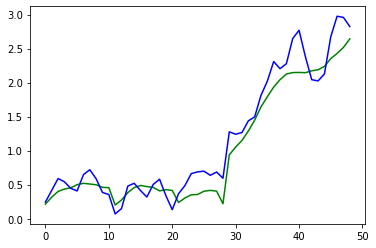

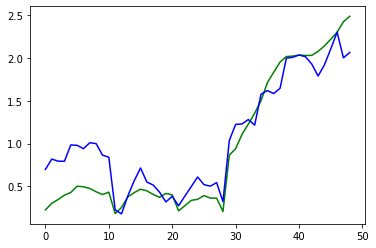

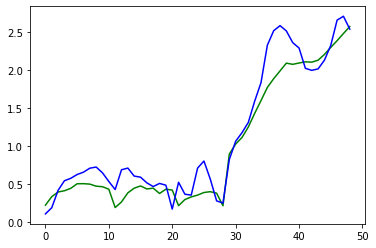

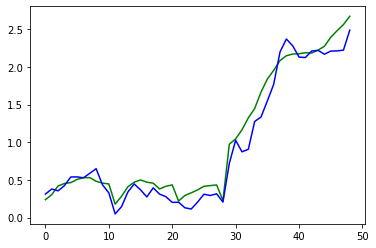

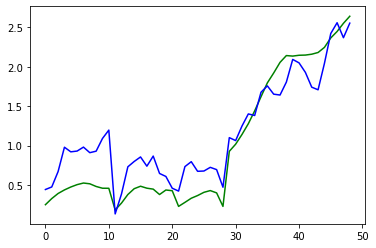

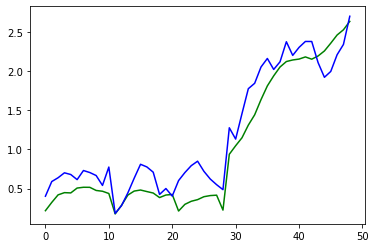

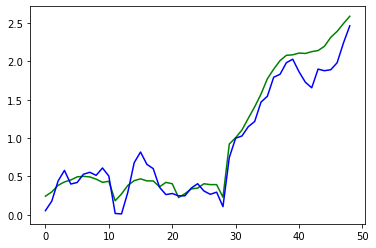

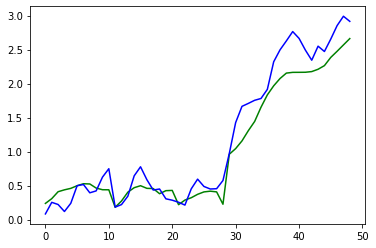

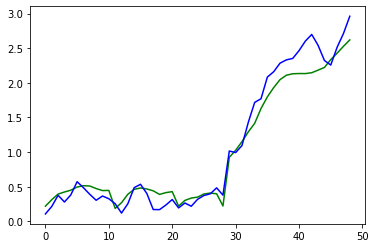

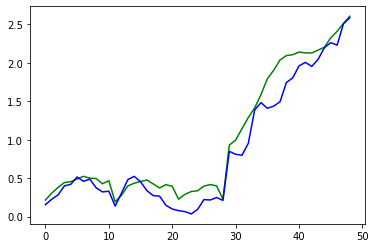

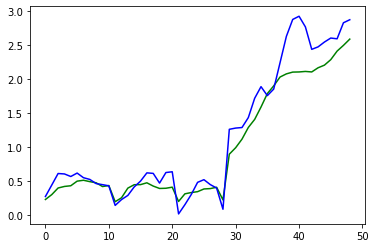

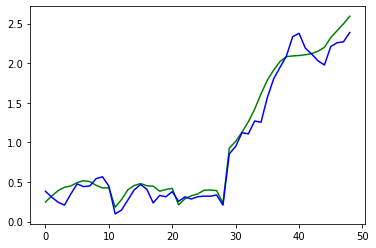

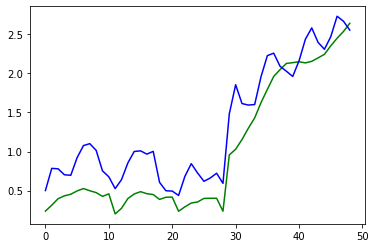

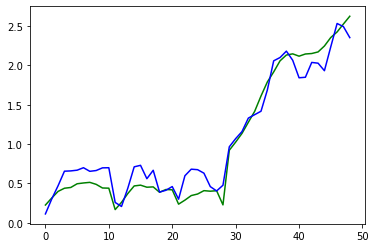

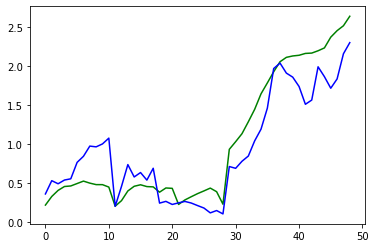

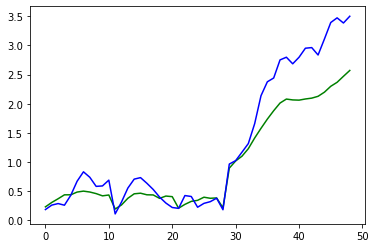

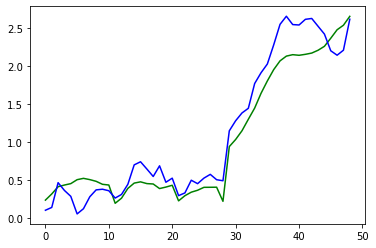

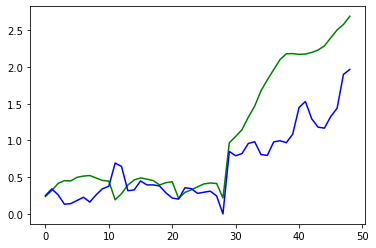

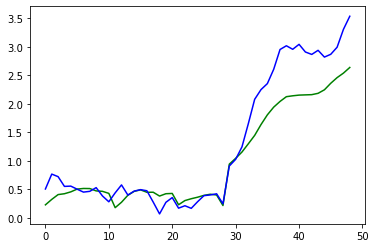

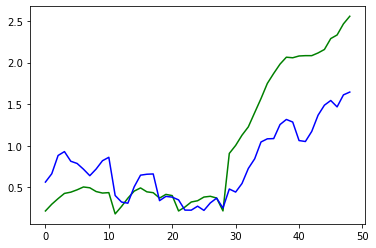

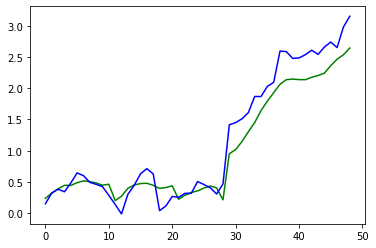

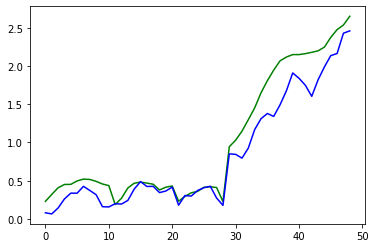

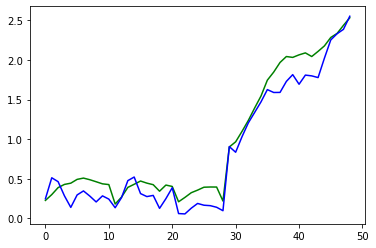

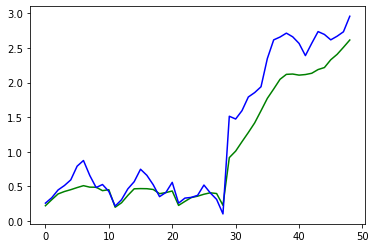

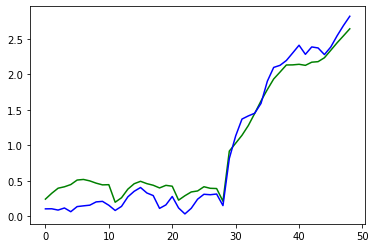

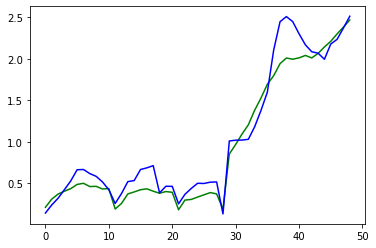

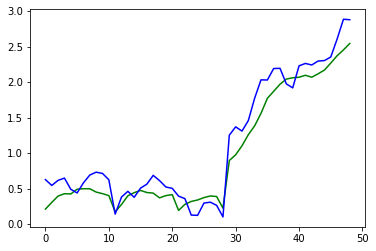

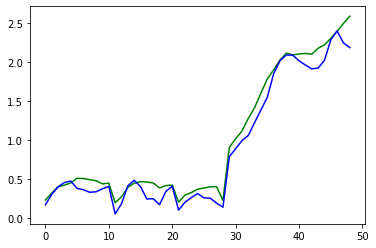

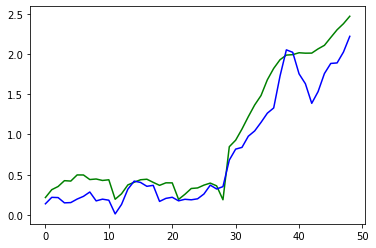

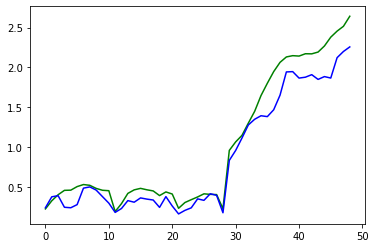

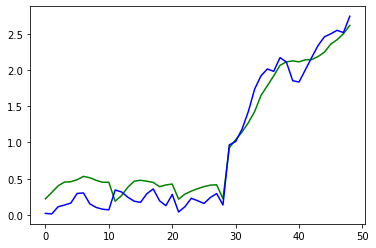

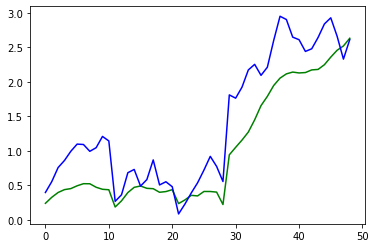

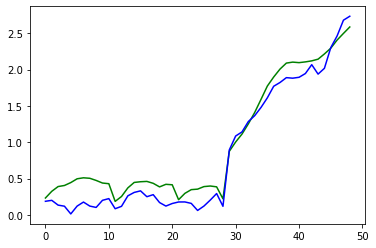

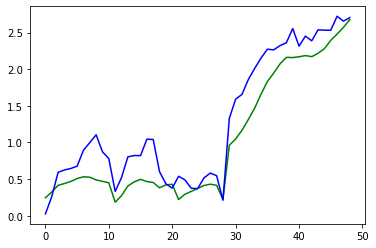

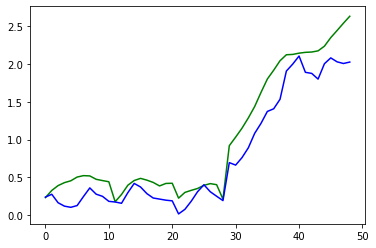

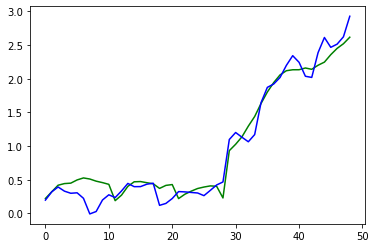

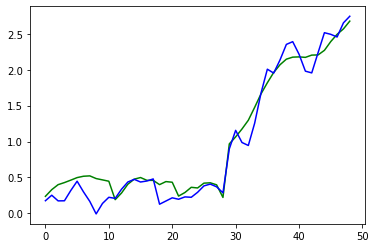

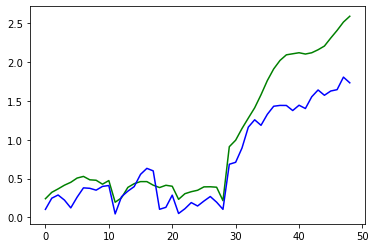

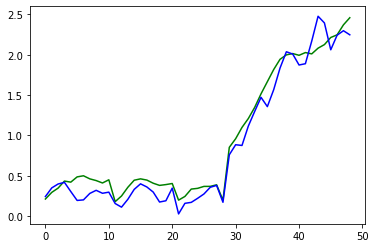

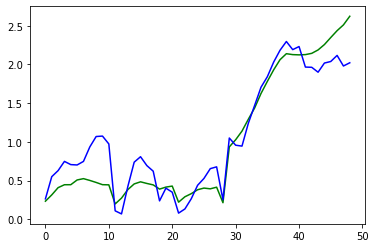

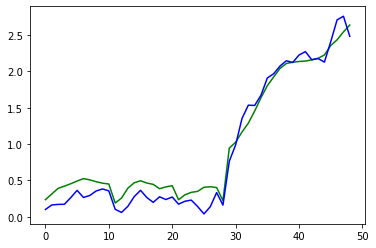

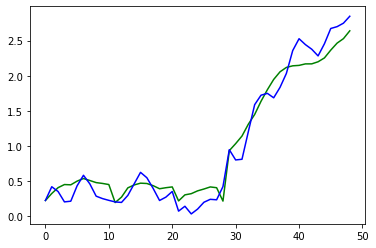

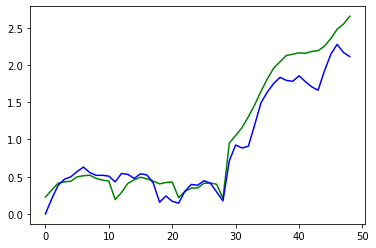

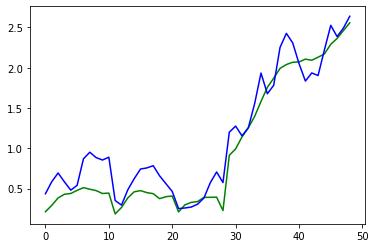

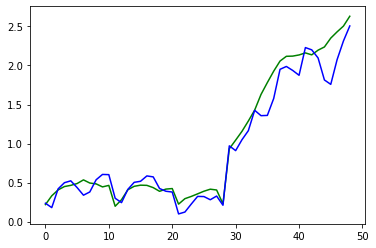

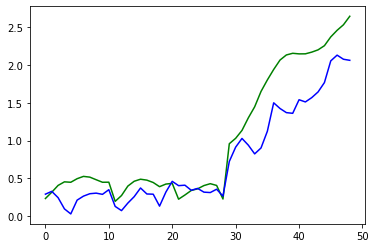

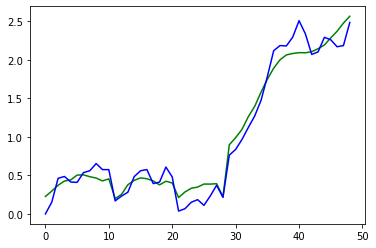

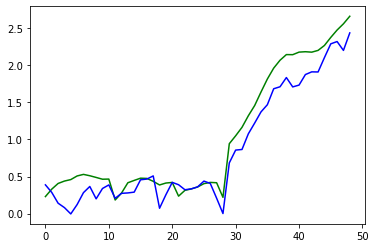

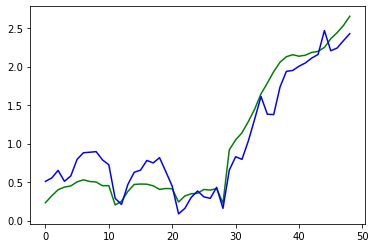

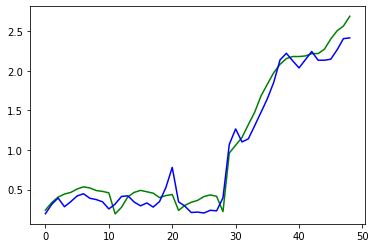

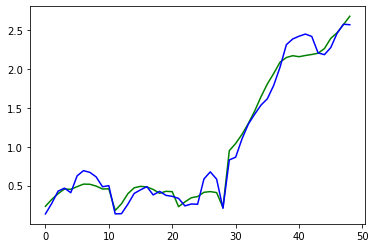

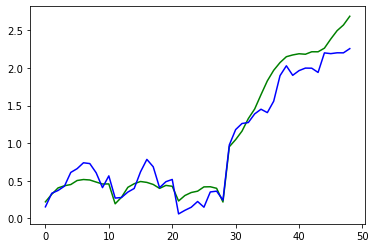

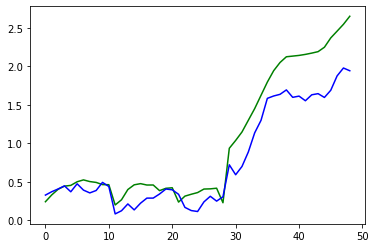

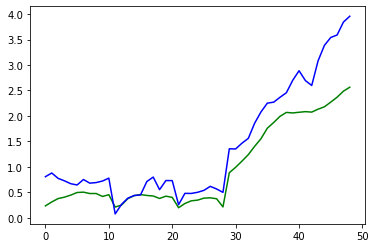

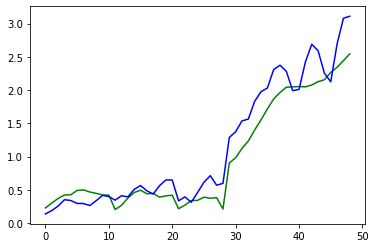

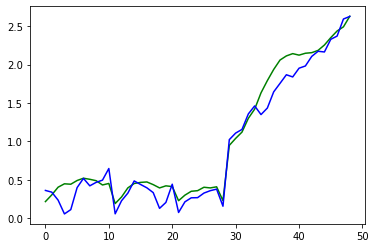

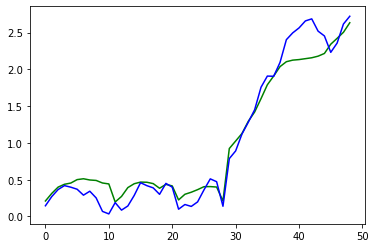

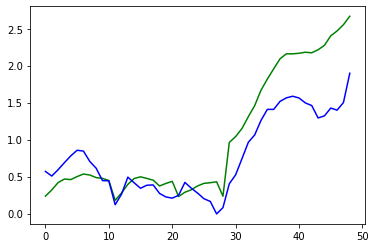

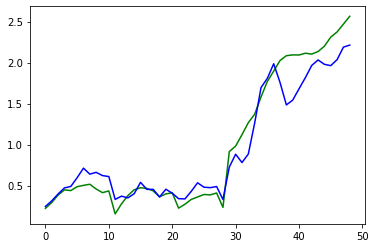

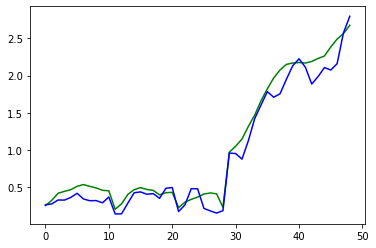

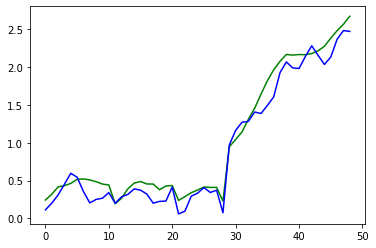

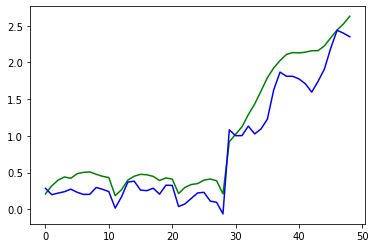

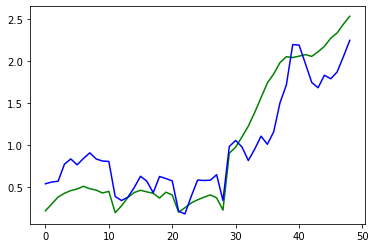

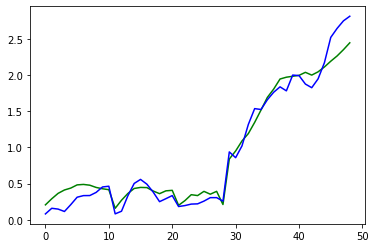

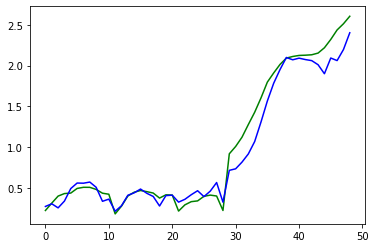

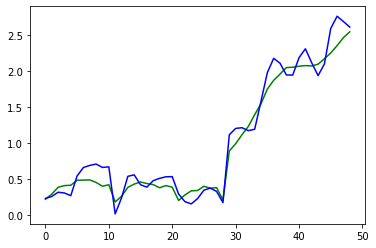

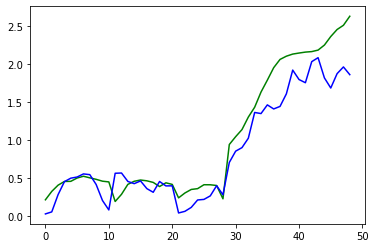

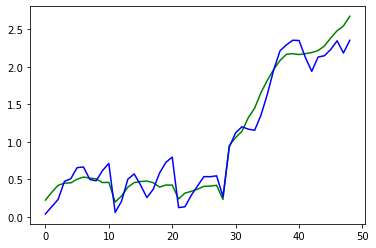

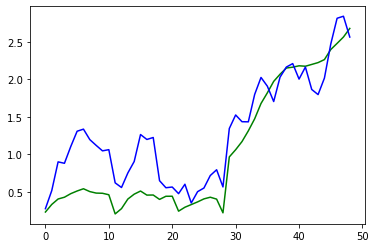

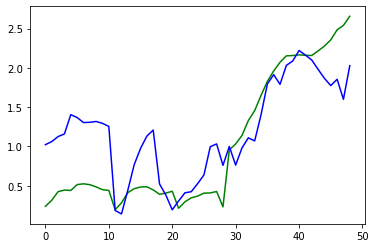

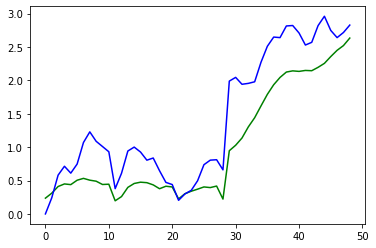

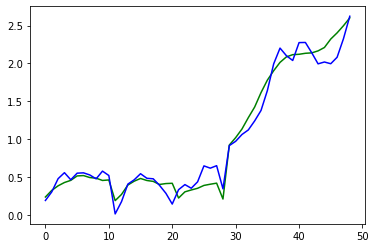

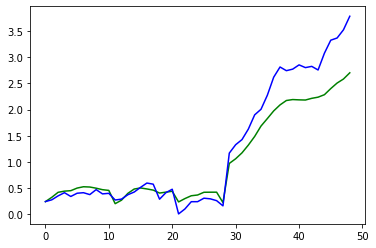

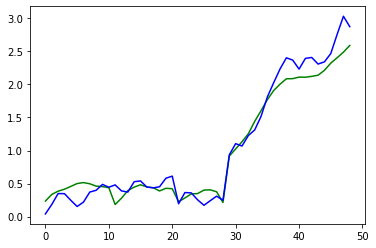

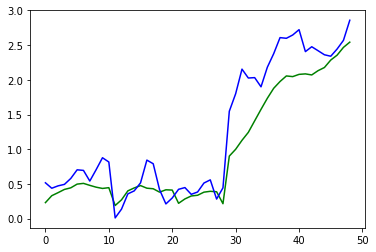

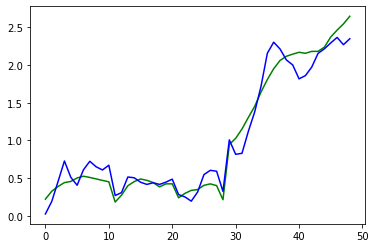

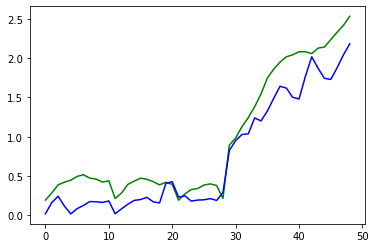

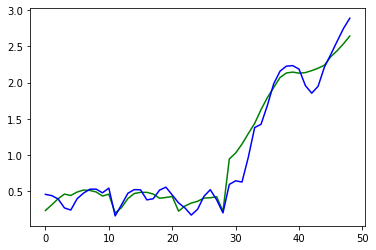

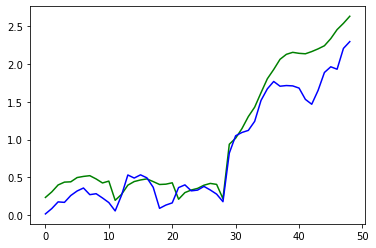

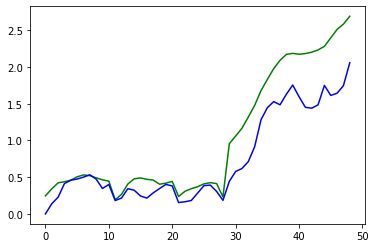

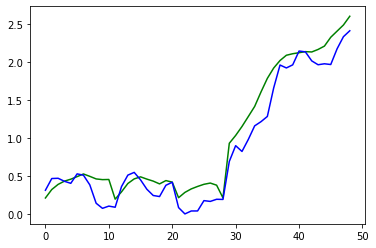

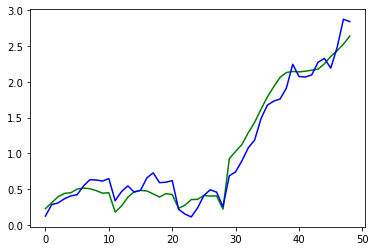

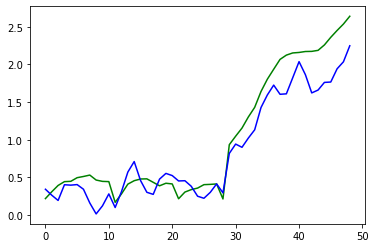

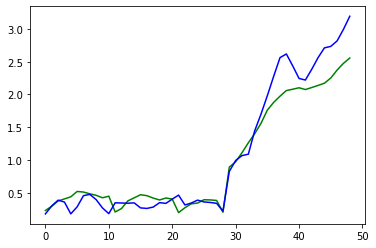

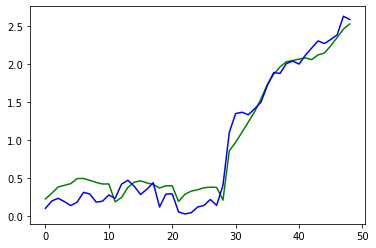

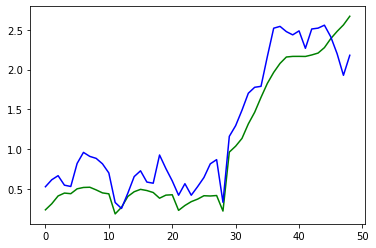

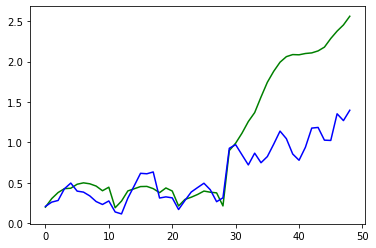

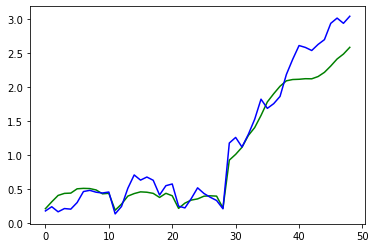

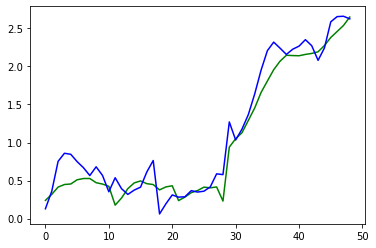

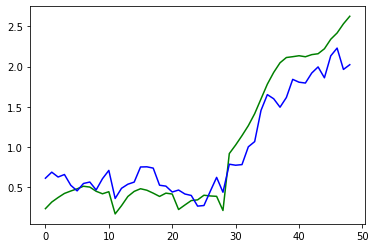

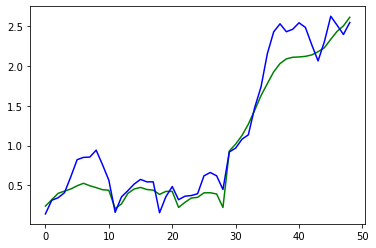

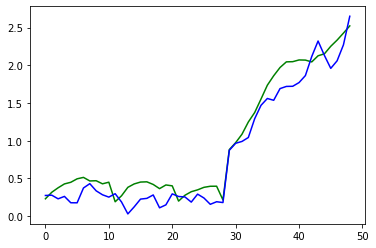

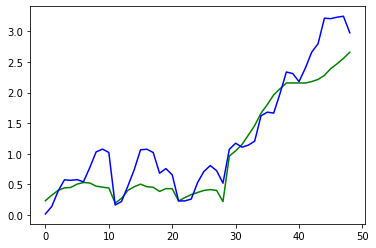

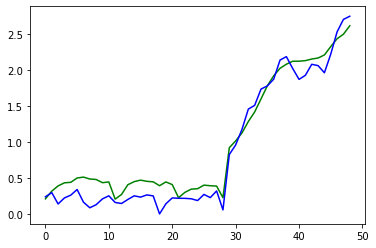

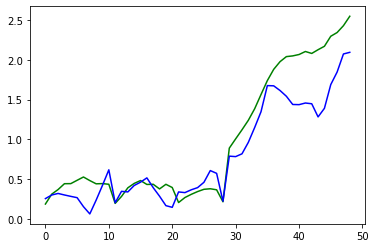

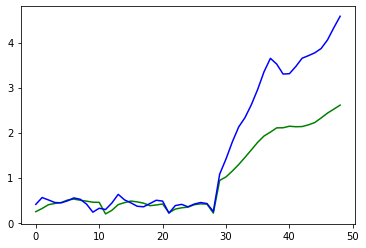

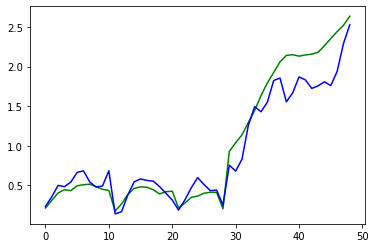

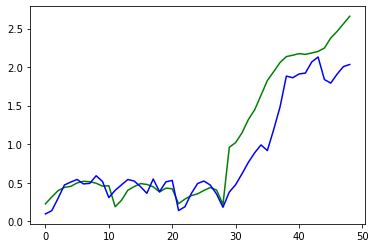

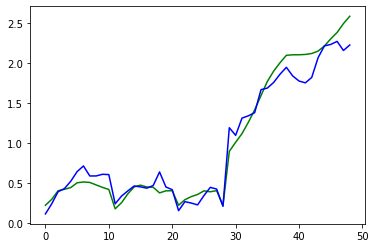

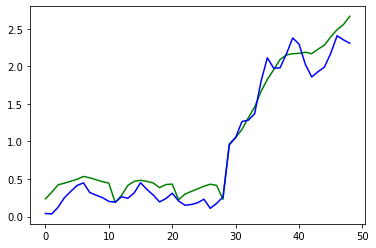

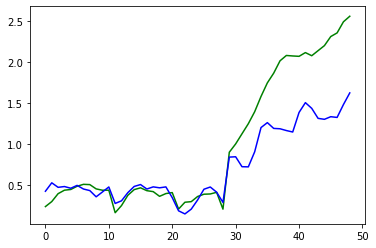

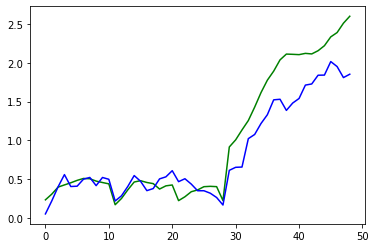

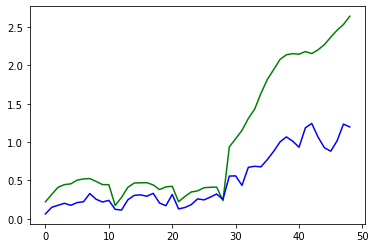

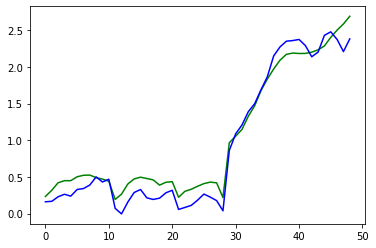

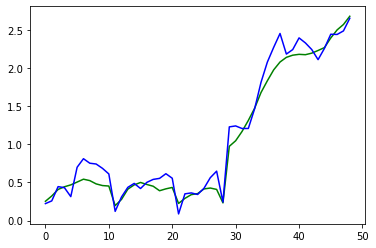

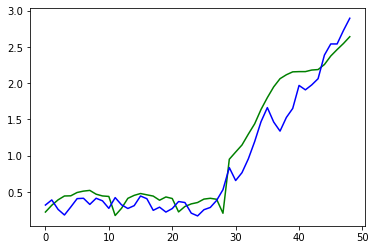

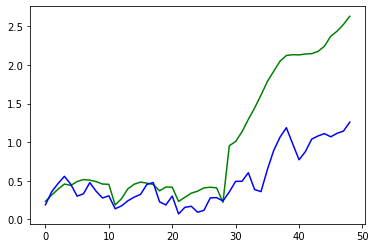

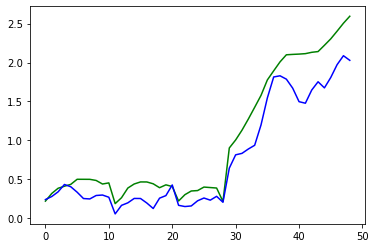

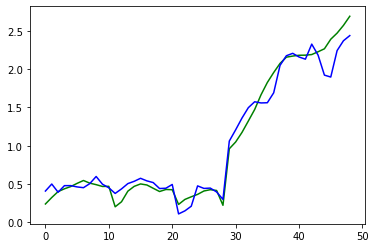

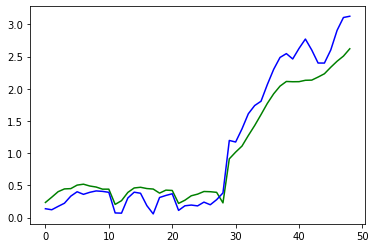

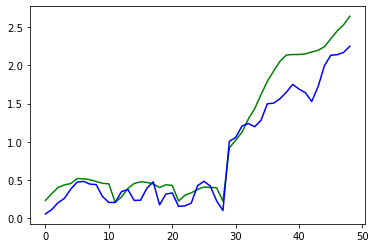

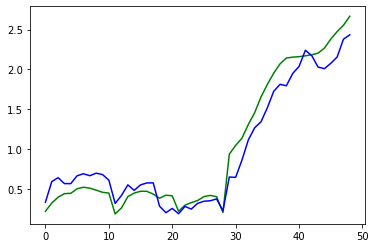

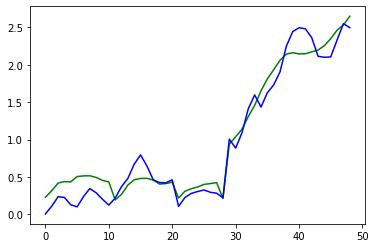

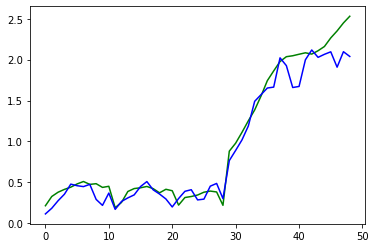

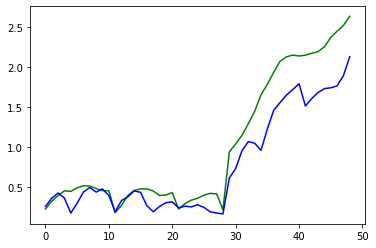

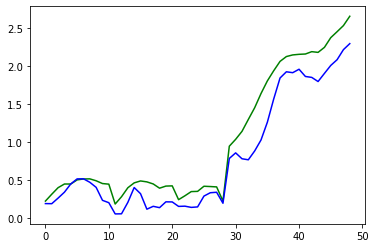

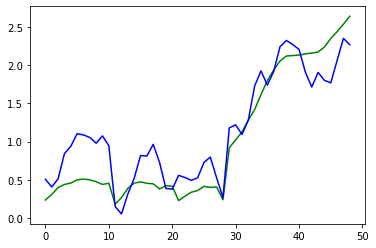

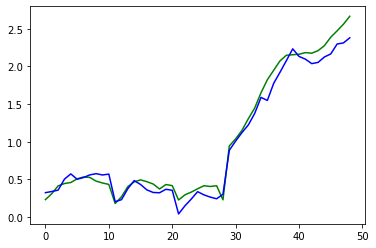

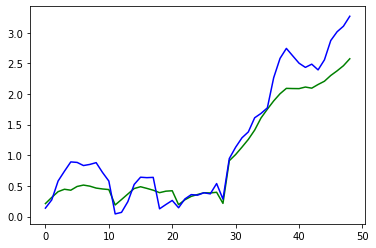

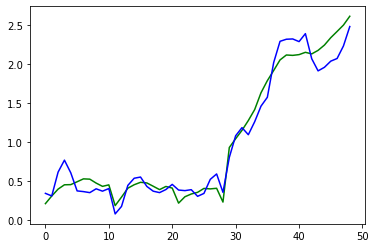

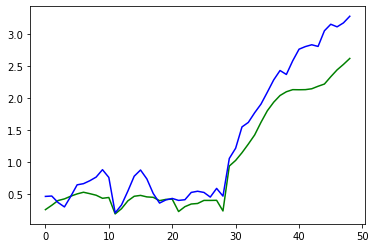

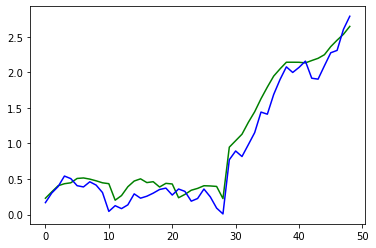

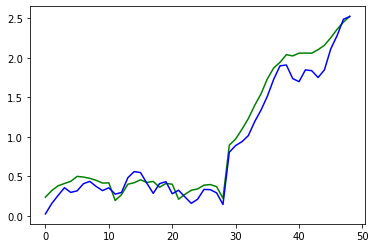

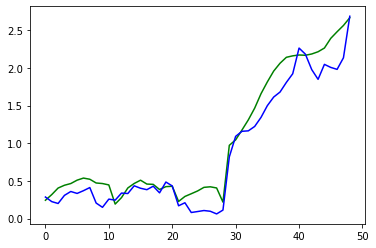

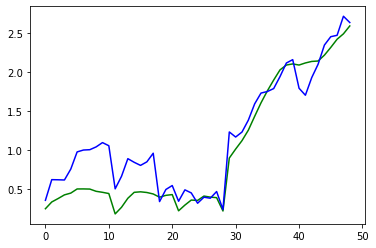

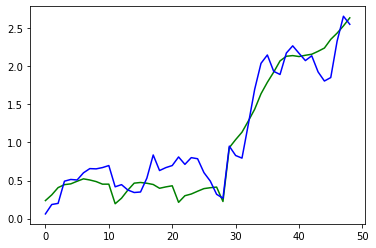

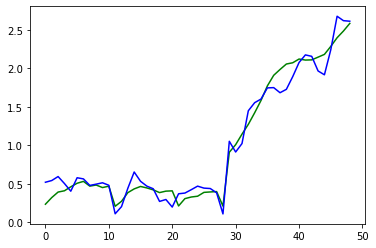

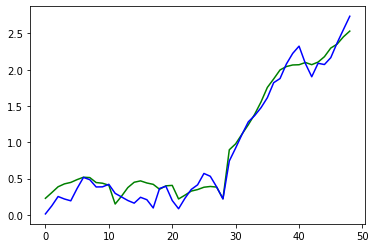

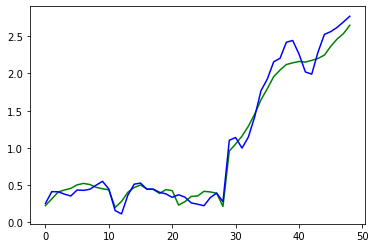

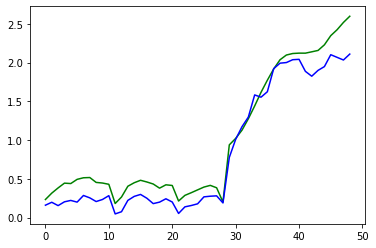

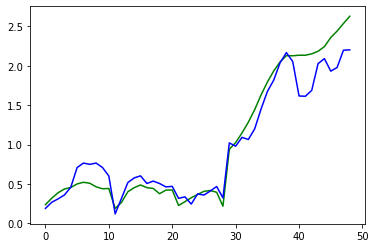

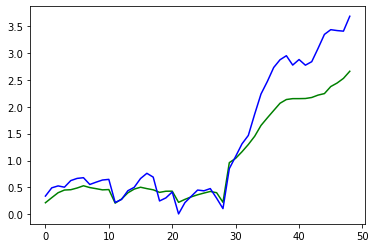

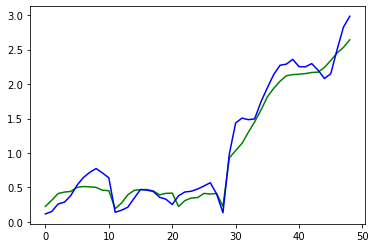

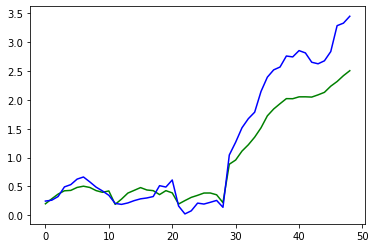

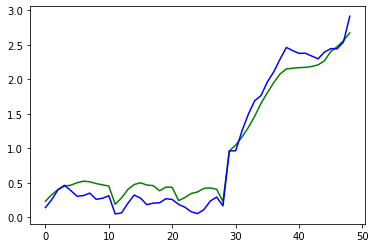

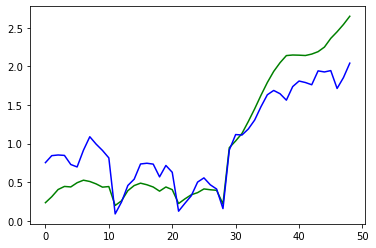

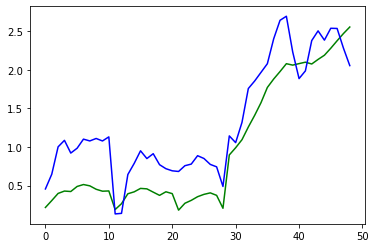

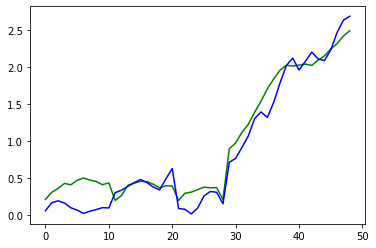

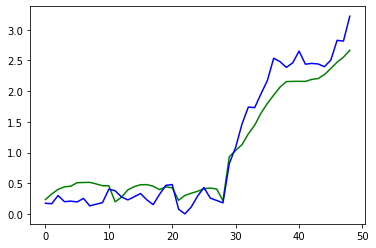

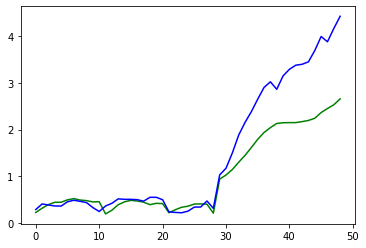

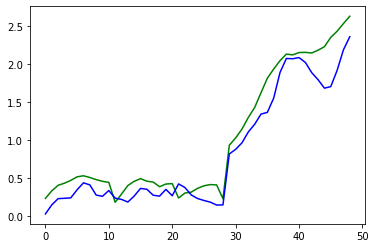

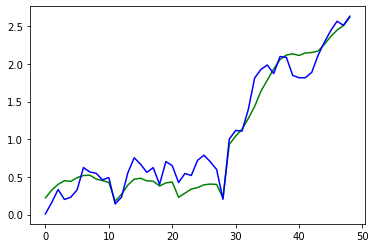

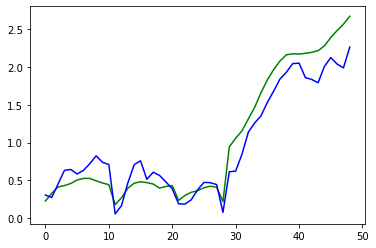

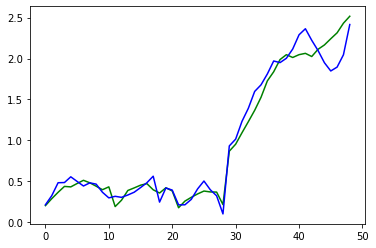

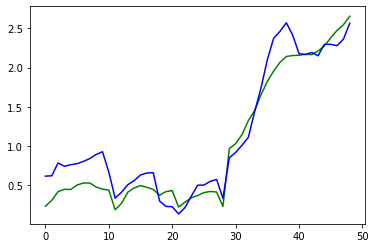

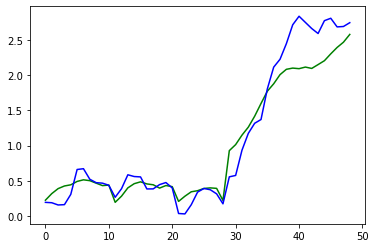

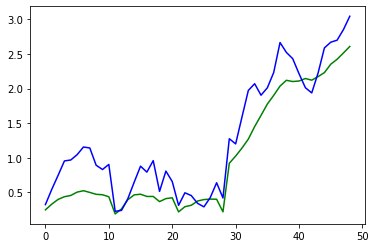

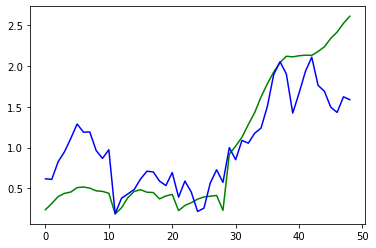

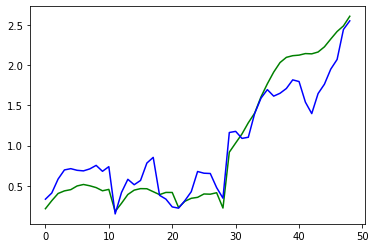

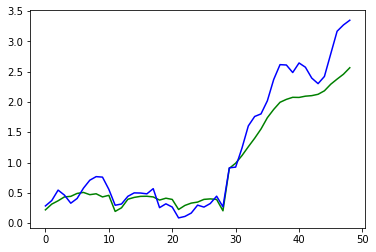

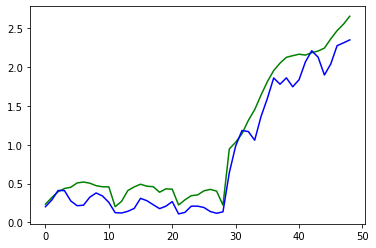

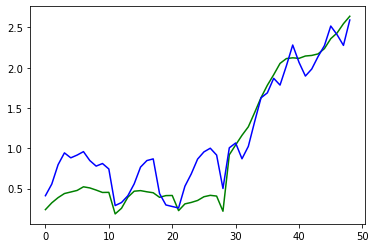

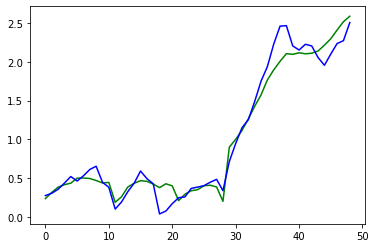

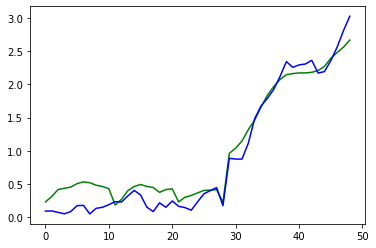

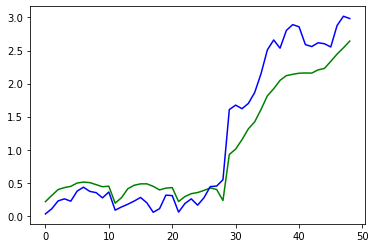

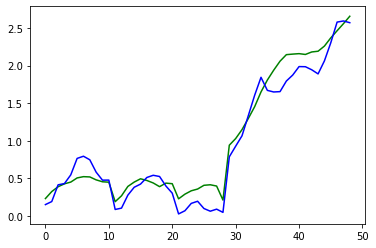

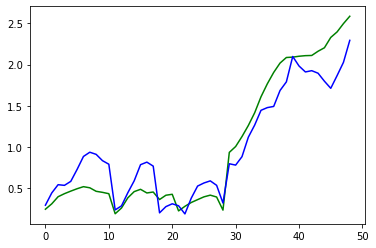

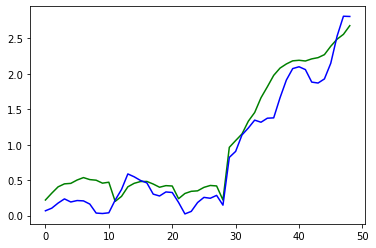

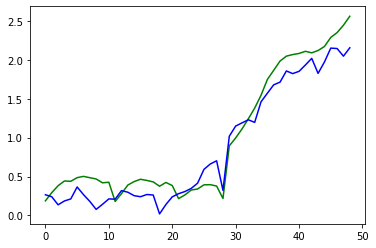

In [58]:
def outputnoise(test_X,test_y):

    for i in range(len(test_X)):

        net_out = net(test_X[i].view(-1, 1,340))
        predict = net_out[0].cpu().detach()
        ground_truth = test_y[i]
        noise = test_X[i]

        plt.plot(predict,color='green')
        plt.plot(ground_truth,color='blue')
        plt.show()
outputnoise(test_X,test_y)

In [40]:
net = CNN()